# ADM-HW5: USA Airport Flight Analysis

Madina Rakhimbayeva 2189800

The USA Airport Dataset, which contains comprehensive details about airports, routes, and traffic patterns is being examined. It is our responsibility to find important information, like the busiest hubs and aircraft paths. We will also investigate the network topology in order to identify groups of connected airports, evaluate their importance, and determine the effects of interruptions.

## **Q1 - Flight Network Analysis**

We begin by importing the necessary libraries for data manipulation, analysis, and visualization. Next, we load the dataset into our environment and perform an initial exploratory analysis. This includes checking for missing values, identifying duplicate entries, and detecting any potential errors or inconsistencies in the data.


In [ ]:
# Import required packages
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from geopy.geocoders import Nominatim
import geocoder
import plotly.express as px
import time

This dataset contains records of over 3.5 million US domestic flights from 1990 to 2009, sourced from the OpenFlights database. It includes 15 columns detailing flight information such as origin and destination cities (with latitude and longitude), passenger numbers, available seats, flight counts, and population data. While some columns, such as latitudes and longitudes, contain missing values, they are not critical for our initial tasks and will be addressed if needed later in the analysis.

In [ ]:
data = pd.read_csv("Airports2.csv")
data.head()

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long
0,MHK,AMW,"Manhattan, KS","Ames, IA",21,30,1,254,2008-10-01,122049,86219,39.14,-96.67,NaN,NaN
1,EUG,RDM,"Eugene, OR","Bend, OR",41,396,22,103,1990-11-01,284093,76034,44.12,-123.21,44.25,-121.15
2,EUG,RDM,"Eugene, OR","Bend, OR",88,342,19,103,1990-12-01,284093,76034,44.12,-123.21,44.25,-121.15
3,EUG,RDM,"Eugene, OR","Bend, OR",11,72,4,103,1990-10-01,284093,76034,44.12,-123.21,44.25,-121.15
4,MFR,RDM,"Medford, OR","Bend, OR",0,18,1,156,1990-02-01,147300,76034,42.37,-122.87,44.25,-121.15


### *Performing data preporatory process (EDA)**

In [ ]:
data.shape

(3606803, 15)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3606803 entries, 0 to 3606802
Data columns (total 15 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Origin_airport          object 
 1   Destination_airport     object 
 2   Origin_city             object 
 3   Destination_city        object 
 4   Passengers              int64  
 5   Seats                   int64  
 6   Flights                 int64  
 7   Distance                int64  
 8   Fly_date                object 
 9   Origin_population       int64  
 10  Destination_population  int64  
 11  Org_airport_lat         float64
 12  Org_airport_long        float64
 13  Dest_airport_lat        float64
 14  Dest_airport_long       float64
dtypes: float64(4), int64(6), object(5)
memory usage: 412.8+ MB


Here we observed that there are missing values in some columns related to airport coordinates. These missing values are not critical for the current task and will be addressed later during the analysis phase.

In [ ]:
data.isnull().sum()

Origin_airport               0
Destination_airport          0
Origin_city                  0
Destination_city             0
Passengers                   0
Seats                        0
Flights                      0
Distance                     0
Fly_date                     0
Origin_population            0
Destination_population       0
Org_airport_lat           6954
Org_airport_long          6954
Dest_airport_lat          6807
Dest_airport_long         6807
dtype: int64

In [ ]:
data.columns

Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long'],
      dtype='object')

Analyzing the dataset, we identified 41,753 duplicate rows. To ensure the accuracy and consistency of our analysis, we proceed to remove these duplicates.

In [ ]:
data.duplicated().sum()

np.int64(41753)

In [ ]:
data = data.drop_duplicates()

#### Feature Engineering

In this section, we are performing several data transformations to better understand and analyze the dataset:

1. **Seats per Flight**: We create a new column *seats_per_flight* that calculates the average number of seats available per flight for each route. If there are no flights (*Flights == 0*), the value is set to 0. This transformation allows us to understand seat distribution relative to the number of flights.

2. **Passengers per Flight**: Similarly, we create a column *passengers_per_flight* that calculates the average number of passengers per flight. Again, if there are no flights, the value is set to 0. This helps to analyze passenger load on each flight route.

3. **Route**: We combine the *Origin_city* and *Destination_city* into a tuple and store it in a new column called *Route*. This allows us to easily analyze the number of flights for each route.

4. **Sorted Route**: This column stores the route as a tuple with the cities sorted alphabetically. This ensures that the route is consistently represented, regardless of the direction, making it easier to aggregate data for each unique route.

These transformations will help improve the analysis of flight patterns and make the dataset more suitable for further exploration.

In [ ]:
# Calculate seats per flight
data['seats_per_flight'] = np.where(
    data['Flights'] != 0, 
    round(data["Seats"] / data['Flights'], 2), 
    0
)
# Calculate passengers per flight
data['passengers_per_flight'] = np.where(
    data['Flights'] != 0, 
    round(data["Passengers"] / data['Flights'], 2), 
    0
)
# Combine origin and destination cities into a 'Route' column (tuple)
data['Route'] = list(zip(data['Origin_city'], data['Destination_city']))
data['Sorted_Route'] = data.apply(
    lambda row: tuple(sorted([row['Origin_city'], row['Destination_city']])),
    axis=1
)

In [ ]:
#Print the number of unique routes
print(f"There are {data['Sorted_Route'].nunique()} unique routes in the dataset.")

There are 18869 unique routes in the dataset.


#### Data Quality
In this section, we will examine the dataset for potential inconsistencies, missing values, and anomalies to ensure the information accurately reflects real-world flights. This includes validating key fields, checking for logical inconsistencies, and handling outliers. Identified issues will be addressed through data cleaning steps such as removal, imputation, or correction, ensuring the dataset is reliable for subsequent analysis and graph construction.

To begin the analysis, we will generate summary statistics for key numerical columns, including passenger counts, flight counts, seat availability, and distances, as well as population data for origin and destination locations. This provides a general understanding of the data distribution, identifies potential outliers, and highlights any unusual patterns, such as extreme values or inconsistencies in calculated metrics like *seats_per_flight* or *passengers_per_flight*.

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
data[["Passengers","Flights",'Seats','Distance','Origin_population','Destination_population',"seats_per_flight","passengers_per_flight"]].describe()

,Passengers,Flights,Seats,Distance,Origin_population,Destination_population,seats_per_flight,passengers_per_flight
count,3565050.00,3565050.00,3565050.00,3565050.00,3565050.00,3565050.00,3565050.00,3565050.00
mean,2720.38,37.60,4095.62,695.44,5864580.27,5889933.98,109.37,69.96
std,4363.21,49.78,6221.54,599.57,7833335.23,7884462.43,65.85,50.15
min,0.00,0.00,0.00,0.00,13005.00,12887.00,0.00,0.00
25%,115.00,2.00,173.00,274.00,1035566.00,1029829.00,50.00,32.97
50%,1161.00,25.00,2074.00,518.00,2404337.00,2404337.00,122.00,66.34
75%,3541.00,55.00,5442.00,926.00,8613622.00,8635706.00,142.00,100.28
max,89597.00,1128.00,147062.00,5095.00,38139592.00,38139592.00,15514.00,940.00


During the data validation process, we identified records with zero flights and seats, which could indicate reporting errors or incomplete data. Specifically:

- **Flights = 0:** These records were removed, as zero flights indicate no actual occurrence of the recorded route.
  
- **Seats = 0 and Passengers > 0:** This situation is logically impossible, as passengers cannot travel without allocated seats. These records were also removed.

- **Origin_airport = Destination_airport:** This scenario suggests an error where flights are recorded between the same origin and destination. While certain routes may have a round-trip structure, flights listed with the same origin and destination for the same date are removed to eliminate data inaccuracies.

By addressing these anomalies, we ensure the dataset reflects plausible and realistic flight operations, improving its reliability for further analysis. However, records with zero seats and zero passengers were retained, as these may reflect valid but empty flights.

In [ ]:
# Filter flights with zero Flights and calculate their proportion in the dataset
flights_zero = data[data['Flights'] == 0]
print(f"{len(flights_zero)} flights have Flights=0. This represents {round(len(flights_zero) / len(data) * 100, 2)}% of the data.")

# Filter flights where Seats are zero but Passengers are greater than zero (logically impossible)
seats_zero_passengers_more = data[(data['Seats'] == 0) & (data['Passengers'] > 0)]
print(f"{len(seats_zero_passengers_more)} flights have Seats=0 but Passengers>0. This represents {round(len(seats_zero_passengers_more) / len(data) * 100, 2)}% of the data.")

# Filter flights where the origin and destination airports are the same (anomalous data)
same_origin_destination = data[data['Origin_airport'] == data['Destination_airport']]
print(f"{len(same_origin_destination)} flights have the same origin and destination. This represents {round(len(same_origin_destination) / len(data) * 100, 2)}% of the data.")

10789 flights have Flights=0. This represents 0.3% of the data.
10 flights have Seats=0 but Passengers>0. This represents 0.0% of the data.
6068 flights have the same origin and destination. This represents 0.17% of the data.


In [ ]:
# Remove rows from the dataset that match any of the identified anomalies:
# - Flights equal to zero (flights_zero)
# - Seats equal to zero but Passengers greater than zero (seats_zero_passengers_more)
# - Same origin and destination airport (same_origin_destination)
dataset = data[~(data.index.isin(flights_zero.index) |  # Exclude rows with Flights=0
                data.index.isin(seats_zero_passengers_more.index) |  # Exclude rows with Seats=0 and Passengers>0
                data.index.isin(same_origin_destination.index)  # Exclude rows with the same origin and destination
                )]

In this step, we identify additional anomalies in the dataset, such as flights with zero seats and cases where the number of passengers exceeds the number of available seats. These records may seem implausible at first glance, but we must approach them cautiously.

Given the limited context and potential gaps in our understanding of how the data was collected, it is possible that these entries reflect real-world scenarios (e.g., misreporting, data aggregation issues, or unique flight arrangements). Removing such data prematurely could result in the loss of valid information.

To maintain the integrity of the dataset, we have decided to retain these records under the assumption that they are accurate. This approach allows us to preserve as much information as possible for analysis, and any patterns or insights that emerge may either validate or challenge these assumptions later. This decision underscores the importance of ongoing validation and contextual understanding during data analysis.

In [ ]:
# Filter rows where the number of seats is zero
seats_zero = dataset[dataset['Seats'] == 0]

# Filter rows where the number of passengers exceeds the number of seats
pass_more_seats = dataset[dataset['Passengers'] > dataset['Seats']]

# Print the number and percentage of flights with Seats=0
print(f"{len(seats_zero)} flights have Seats=0. This represents {round(len(seats_zero)/len(dataset)*100, 2)}% of the dataset.")

# Print the number and percentage of flights with more passengers than seats
print(f"{len(pass_more_seats)} flights have more passengers than seats. This represents {round(len(pass_more_seats)/len(dataset)*100, 2)}% of the dataset.")

281830 flights have Seats=0. This represents 7.94% of the dataset.
261 flights have more passengers than seats. This represents 0.01% of the dataset.


Building on the earlier discussion of potential anomalies in the dataset, another unusual pattern emerges: some flights appear to be recorded twice—once from the origin to the destination and again from the destination to the origin. While this could represent valid round-trip data, it is more likely due to duplication in the recording process. This step investigates and quantifies the extent of such duplicate records, ensuring that our dataset remains as accurate and reliable as possible.

In [ ]:
# Identify potential duplicate flight records based on route, date, and flight details
duplicates = dataset[dataset.duplicated(
    subset=['Sorted_Route', 'Fly_date', 'Flights', 'Seats', "Passengers"], 
    keep=False
)]

# Print the number and percentage of duplicate records in the dataset
print(f"{len(duplicates)} flights appear to be recorded as duplicates—one from origin to destination and another from destination to origin. This accounts for {round(len(duplicates) / len(dataset) * 100, 2)}% of the dataset.")


119261 flights appear to be recorded as duplicates—one from origin to destination and another from destination to origin. This accounts for 3.36% of the dataset.


In [ ]:
## Here we print an example of what can be a duplicated record with reversed Origin_airport and Destination_airport
# duplicates.sort_values(by=['Fly_date','Flights','Passengers','Seats'])[20:22]
duplicates.sort_values(by=['Sorted_Route','Flights'])[:2]

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long,seats_per_flight,passengers_per_flight,Route,Sorted_Route
1546030,ANC,ABR,"Anchorage, AK","Aberdeen, SD",2,9,1,2316,2008-04-01,365790,38991,61.17,-150.00,45.45,-98.42,9.00,2.00,"(Anchorage, AK, Aberdeen, SD)","(Aberdeen, SD, Anchorage, AK)"
1919269,ABR,ANC,"Aberdeen, SD","Anchorage, AK",2,9,1,2316,2008-04-01,38991,365790,45.45,-98.42,61.17,-150.00,9.00,2.00,"(Aberdeen, SD, Anchorage, AK)","(Aberdeen, SD, Anchorage, AK)"


After filtering the dataset to address known anomalies, we proceed to examine the summary statistics of key variables. While these statistics provide an overview of the data's distribution, they also reveal new potential inconsistencies. For instance:

- The *Distance* column contains a minimum value of 0, even though flights with the same origin and destination have been removed.
- The *seats_per_flight* and *passengers_per_flight* columns exhibit unusually high maximum values, which may suggest errors or outliers in the data.
- The *Flights* column shows potentially implausible high values for certain routes.

These observations warrant further investigation to identify and handle outliers appropriately, ensuring that our dataset reflects realistic flight operations. In the following steps, we will analyze these outliers in greater detail and determine an appropriate course of action.

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
#Use describe() function to calculate mean, std, min, max for the chosen columns
dataset[["Passengers","Flights",'Seats','Distance','Origin_population','Destination_population',"seats_per_flight","passengers_per_flight"]].describe()

,Passengers,Flights,Seats,Distance,Origin_population,Destination_population,seats_per_flight,passengers_per_flight
count,3548687.00,3548687.00,3548687.00,3548687.00,3548687.00,3548687.00,3548687.00,3548687.00
mean,2732.77,37.76,4114.24,696.95,5865708.36,5891186.36,109.80,70.26
std,4369.40,49.80,6229.74,599.29,7830098.61,7881738.87,65.61,50.05
min,0.00,1.00,0.00,0.00,13005.00,12887.00,0.00,0.00
25%,117.00,3.00,176.00,277.00,1036319.00,1030597.00,50.00,33.23
50%,1178.00,26.00,2106.00,522.00,2404337.00,2404337.00,122.00,66.69
75%,3556.00,56.00,5457.00,927.00,8613622.00,8635706.00,142.00,100.46
max,89597.00,1128.00,147062.00,5018.00,38139592.00,38139592.00,15514.00,940.00


##### seats_per_flight

In [ ]:
# Check the distribution
high_seats_threshold = dataset['seats_per_flight'].quantile(0.999)  # 99th percentile
print(f"999th percentile for seats_per_flight: {high_seats_threshold}")

# Identify flights with implausibly high seats_per_flight
implausible_seats = dataset[dataset['seats_per_flight'] > high_seats_threshold]
print(f"{len(implausible_seats)} flights have seats_per_flight > {high_seats_threshold}.")


999th percentile for seats_per_flight: 435.0
3444 flights have seats_per_flight > 435.0.


By establishing a maximum threshold of 600 for the *seats_per_flight* column we guarantee that the dataset represents realistic flight operations. Even the biggest commercial aircraft hardly ever fly above this limit in a single flight, therefore this threshold is in line with real-world constraints. In order to preserve data integrity, flights that exceeded this threshold were recognized as outliers and eliminated from the dataset. The updated dataset size and the number of outliers eliminated are reported below.

In [ ]:
# Set a threshold for maximum seats_per_flight
max_reasonable_seats = 600 
# Identify flights with implausibly high seats_per_flight
outliers_seats = dataset[dataset['seats_per_flight'] > max_reasonable_seats]
print(f"{len(outliers_seats)} flights have seats_per_flight > {max_reasonable_seats}.")
dataset = dataset[dataset['seats_per_flight'] <= max_reasonable_seats]
print(f"Removed {len(outliers_seats)} flights that have seats_per_flight > {max_reasonable_seats}. ")
print(f"Dataset cleaned. Remaining records: {len(dataset)}.")


18 flights have seats_per_flight > 600.
Removed 18 flights that have seats_per_flight > 600. 
Dataset cleaned. Remaining records: 3548669.


In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
dataset[["Passengers","Flights",'Seats','Distance','Origin_population','Destination_population',"seats_per_flight","passengers_per_flight"]].describe()

,Passengers,Flights,Seats,Distance,Origin_population,Destination_population,seats_per_flight,passengers_per_flight
count,3548669.00,3548669.00,3548669.00,3548669.00,3548669.00,3548669.00,3548669.00,3548669.00
mean,2732.78,37.76,4114.20,696.95,5865704.79,5891167.35,109.79,70.26
std,4369.41,49.80,6229.51,599.29,7830102.80,7881697.98,64.32,50.05
min,0.00,1.00,0.00,0.00,13005.00,12887.00,0.00,0.00
25%,117.00,3.00,176.00,277.00,1036319.00,1030597.00,50.00,33.23
50%,1178.00,26.00,2106.00,522.00,2404337.00,2404337.00,122.00,66.69
75%,3556.00,56.00,5457.00,927.00,8613622.00,8635706.00,142.00,100.46
max,89597.00,1128.00,147062.00,5018.00,38139592.00,38139592.00,600.00,553.00


##### Distance

During the data validation process, we identified a set of records where the *Distance* field was recorded as zero. This is an anomaly, as it's highly unlikely for a flight to have no distance. In this section, we are addressing this issue by cross-referencing the routes with known valid distances for certain routes where this error occurred.

The logic follows these steps:

1. **Identifying the Anomaly:** We first filter the dataset to capture all records where the *Distance* is equal to zero.
2. **Correcting the Values:** For each of these routes, we manually update the *Distance* values with the correct distances, which are verified against the known real-world data present in the dataset.
3. **Final Check:** After correcting the dataset, we recheck to ensure that no records remain with *Distance = 0*. If there are any residual records with zero distance, we proceed to remove them from the dataset to avoid skewing the analysis.

This approach ensures that the dataset reflects realistic and plausible flight data, improving its quality for further analysis.



In [ ]:
# Identify routes with Distance = 0
distance_zero = dataset[dataset['Distance']==0]
distance_zero.head(5)

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long,seats_per_flight,passengers_per_flight,Route,Sorted_Route
184358,MEM,MMI,"Memphis, TN","Athens, TN",0,0,1,0,1999-08-01,1169733,46395,35.04,-89.98,NaN,NaN,0.00,0.00,"(Memphis, TN, Athens, TN)","(Athens, TN, Memphis, TN)"
184371,LRD,MMI,"Laredo, TX","Athens, TN",0,0,1,0,1999-08-01,193180,46395,27.54,-99.46,NaN,NaN,0.00,0.00,"(Laredo, TX, Athens, TN)","(Athens, TN, Laredo, TX)"
294045,LAS,AFW,"Las Vegas, NV","Dallas, TX",82,139,1,0,1994-07-01,938611,8613622,36.08,-115.15,32.99,-97.32,139.00,82.00,"(Las Vegas, NV, Dallas, TX)","(Dallas, TX, Las Vegas, NV)"
298083,AFW,DFW,"Dallas, TX","Dallas, TX",82,139,1,0,1994-07-01,8613622,8613622,32.99,-97.32,32.90,-97.04,139.00,82.00,"(Dallas, TX, Dallas, TX)","(Dallas, TX, Dallas, TX)"
436328,MMI,LRD,"Athens, TN","Laredo, TX",0,0,1,0,1999-08-01,46395,193180,NaN,NaN,27.54,-99.46,0.00,0.00,"(Athens, TN, Laredo, TX)","(Athens, TN, Laredo, TX)"


In [ ]:
# Iterate over each erroneous route
for route in distance_zero['Sorted_Route'].unique():
    # Find the correct distance for this route in the dataset
    correct_distance = dataset[(dataset['Sorted_Route'] == route) & (dataset['Distance'] > 0)]['Distance'].unique()
    
    # If a unique, valid distance exists, update the erroneous records
    if len(correct_distance) == 1:
        dataset.loc[(dataset['Sorted_Route'] == route) & (dataset['Distance'] == 0), 'Distance'] = correct_distance[0]

print("Erroneous distances replaced with correct values.")


Erroneous distances replaced with correct values.


In [ ]:
# Re-filter the dataset for records that originally had Distance = 0
corrected_distance_zero = dataset[(dataset['Sorted_Route'].isin(distance_zero['Sorted_Route']))
                                  &(dataset['Flights'].isin(distance_zero['Flights']))
                                  &(dataset['Passengers'].isin(distance_zero['Passengers']))
                                  &(dataset['Fly_date'].isin(distance_zero['Fly_date']))]
corrected_distance_zero.head(5)

,Origin_airport,Destination_airport,Origin_city,Destination_city,Passengers,Seats,Flights,Distance,Fly_date,Origin_population,Destination_population,Org_airport_lat,Org_airport_long,Dest_airport_lat,Dest_airport_long,seats_per_flight,passengers_per_flight,Route,Sorted_Route
184358,MEM,MMI,"Memphis, TN","Athens, TN",0,0,1,307,1999-08-01,1169733,46395,35.04,-89.98,NaN,NaN,0.00,0.00,"(Memphis, TN, Athens, TN)","(Athens, TN, Memphis, TN)"
184371,LRD,MMI,"Laredo, TX","Athens, TN",0,0,1,1031,1999-08-01,193180,46395,27.54,-99.46,NaN,NaN,0.00,0.00,"(Laredo, TX, Athens, TN)","(Athens, TN, Laredo, TX)"
294045,LAS,AFW,"Las Vegas, NV","Dallas, TX",82,139,1,0,1994-07-01,938611,8613622,36.08,-115.15,32.99,-97.32,139.00,82.00,"(Las Vegas, NV, Dallas, TX)","(Dallas, TX, Las Vegas, NV)"
298083,AFW,DFW,"Dallas, TX","Dallas, TX",82,139,1,0,1994-07-01,8613622,8613622,32.99,-97.32,32.90,-97.04,139.00,82.00,"(Dallas, TX, Dallas, TX)","(Dallas, TX, Dallas, TX)"
436324,MMI,LRD,"Athens, TN","Laredo, TX",0,0,1,1031,1999-11-01,46395,193180,NaN,NaN,27.54,-99.46,0.00,0.00,"(Athens, TN, Laredo, TX)","(Athens, TN, Laredo, TX)"


In [ ]:
still_zero_distance = dataset[dataset['Distance']==0]
print(f"Still {len(still_zero_distance)} flights have zero distance.")
dataset = dataset[dataset['Distance']>0]
print(f"Dataset cleaned. {len(still_zero_distance)} flights removed.")

Still 4 flights have zero distance.
Dataset cleaned. 4 flights removed.


##### Flights

During analysis, it is observed that the maximum value for *Flights* was extremely high. To address this, I examined the 999th percentile, which is below 500 flights per day. Based on this, then set a threshold of 500 flights per day, similar to the approach used for *seats_per_flight*. Any records with more than 500 flights in a day will be considered outliers and removed from the dataset. This threshold helps to maintain more reasonable and realistic dataset while still preserving valuable information.


In [ ]:
# Inspect the distribution
high_flights_threshold = dataset['Flights'].quantile(0.999)  # 99th percentile
print(f"999th percentile for Flights: {high_flights_threshold}")

# Identify flights with implausibly high Flights
outliers_flights = dataset[dataset['Flights'] > high_flights_threshold]
print(f"{len(outliers_flights)} flights have Flights > {high_flights_threshold}.")


999th percentile for Flights: 468.0
3531 flights have Flights > 468.0.


Here we also print an example of what we mean by unusual flights performed in the same day.

In [ ]:

# Group by Origin_city and Destination_city, then sum Flights
# Unusual_routes = pd.DataFrame(outliers_flights.groupby(['Origin_city', 'Destination_city','Fly_date'])['Flights'].sum())
Unusual_routes = pd.DataFrame(outliers_flights.groupby(['Sorted_Route','Fly_date'])['Flights'].sum())
Unusual_routes = Unusual_routes.sort_values(by="Flights", ascending=False).reset_index()
#Print an example of unusual flights performed in the same day.
Unusual_routes.head()


,Sorted_Route,Fly_date,Flights
0,"(Honolulu, HI, Kahului, HI)",1996-01-01,3480
1,"(Honolulu, HI, Kahului, HI)",2000-01-01,3469
2,"(Los Angeles, CA, San Diego, CA)",2002-10-01,3377
3,"(Honolulu, HI, Kahului, HI)",1999-12-01,3362
4,"(Honolulu, HI, Kahului, HI)",1995-12-01,3325


In [ ]:
Unusual_routes['Sorted_Route'].nunique()

36

In [ ]:
# Set a threshold for maximum Flights
max_reasonable_flights = 500 
# Identify flights with implausibly high Flights
high_flights = dataset[dataset['Flights'] > max_reasonable_flights]
print(f"{len(high_flights)} flights have Flights > {max_reasonable_flights}.")
dataset = dataset[dataset['Flights'] <= max_reasonable_flights]
print(f"Removed {len(high_flights)} flights that have Flights > {max_reasonable_flights}.")
print(f"Dataset cleaned. Remaining records: {len(dataset)}.")

2609 flights have Flights > 500.
Removed 2609 flights that have Flights > 500.
Dataset cleaned. Remaining records: 3546056.


These were the routes with extremely high values for their Flights.

In [ ]:
high_flights['Sorted_Route'].unique()

array([('Hilo, HI', 'Honolulu, HI'), ('Atlanta, GA', 'Tampa, FL'),
       ('Boston, MA', 'New York, NY'), ('Boston, MA', 'Newark, NJ'),
       ('Boston, MA', 'Washington, DC'), ('Chicago, IL', 'Dallas, TX'),
       ('Dallas, TX', 'Houston, TX'), ('Dallas, TX', 'New York, NY'),
       ('Newark, NJ', 'Washington, DC'), ('Atlanta, GA', 'Columbus, MS'),
       ('Chicago, IL', 'New York, NY'),
       ('Chicago, IL', 'Indianapolis, IN'),
       ('Houston, TX', 'New Orleans, LA'),
       ('Honolulu, HI', 'Kahului, HI'),
       ('Los Angeles, CA', 'Oakland, CA'),
       ('Los Angeles, CA', 'Phoenix, AZ'),
       ('Las Vegas, NV', 'Phoenix, AZ'), ('Portland, OR', 'Seattle, WA'),
       ('Seattle, WA', 'Spokane, WA'),
       ('San Francisco, CA', 'Seattle, WA'),
       ('Appleton, WI', 'Cincinnati, OH'),
       ('New York, NY', 'Washington, DC'),
       ('Fort Lauderdale, FL', 'New York, NY'),
       ('Cincinnati, OH', 'Savannah, GA'),
       ('Cincinnati, OH', 'Cleveland, OH'),
       ('Los Ang

In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)
dataset[["Passengers","Flights",'Seats','Distance','Origin_population','Destination_population',"seats_per_flight","passengers_per_flight"]].describe()

,Passengers,Flights,Seats,Distance,Origin_population,Destination_population,seats_per_flight,passengers_per_flight
count,3546056.00,3546056.00,3546056.00,3546056.00,3546056.00,3546056.00,3546056.00,3546056.00
mean,2703.82,37.33,4068.39,697.28,5863123.81,5888546.03,109.79,70.26
std,4212.17,47.16,5950.32,599.35,7827132.50,7878842.21,64.33,50.06
min,0.00,1.00,0.00,2.00,13005.00,12887.00,0.00,0.00
25%,117.00,3.00,175.00,278.00,1036319.00,1030597.00,50.00,33.22
50%,1175.00,26.00,2100.00,522.00,2404337.00,2404337.00,122.00,66.67
75%,3549.00,55.00,5452.00,927.00,8613622.00,8635706.00,142.00,100.50
max,75912.00,500.00,89927.00,5018.00,38139592.00,38139592.00,600.00,553.00


### **analyze_graph_features(flight_network)**

The first task involves implementing a function, **analyze_graph_features(flight_network)**, which analyzes the flight network by performing several key operations. 

First, it calculates the number of airports (*nodes*) and flights (*edges*) within the graph. 
It then computes the graph's *density* using the appropriate formula. 
The function also evaluates both *in-degree* and *out-degree* for each airport and visualizes these values through histograms. 
Airports with degrees higher than the 90th percentile are classified as **hubs**. Finally, the function assesses whether the graph is sparse or dense based on its density.

To analyze the flight network, we first created a directed graph *G* using the *networkx* library, where each airport is a node and each flight between airports is an edge with the weight corresponding to the number of flights.

1. **Grouping Data**: We start by aggregating the dataset to group flight data by *Origin_airport*, *Destination_airport*, and *Route*, summing the number of flights for each unique combination of these factors.

2. **Creating the Dictionary**: We then extract a dictionary where the key is a tuple of *Origin_airport* and *Destination_airport*, and the value is the total number of flights between those two airports.

3. **Building the Graph**: Using the dictionary, we create a directed graph where each edge represents a flight route between two airports. The weight of each edge is the number of flights between the airports.

In [ ]:
# Group by 'Origin_airport', 'Destination_airport', and 'Route', summing the 'Flights'
route_flights = dataset.groupby(['Origin_airport', 'Destination_airport', 'Route'])['Flights'].sum().reset_index()

# Create the dictionary with only 'Origin_airport', 'Destination_airport', and 'Flights'
route_airports = route_flights[['Origin_airport', 'Destination_airport', 'Flights']].set_index(['Origin_airport', 'Destination_airport']).to_dict()['Flights']

# Display the route_airports dictionary
# print(route_airports)

In [ ]:
# Create the graph
G = nx.DiGraph()

# Adding edges with weights from route_airports dictionary
for route, flights in route_airports.items():
    origin, destination = route  # Unpacking the tuple
    G.add_edge(origin, destination, weight=flights)

We start by creating an adjacency matrix to represent the flight network, where rows and columns correspond to airports, and each entry indicates the number of flights between two airports. Here's the process:

1. Extract all unique airports from the dataset to define the nodes of the graph.
2. Assign each airport a unique index using a dictionary (*node_to_index*).
3. Initialize a square matrix (*adj_matrix*) filled with zeros, where the size equals the number of unique airports.
4. Fill the matrix based on the flight data, with values representing the number of flights from the origin to the destination airport.

After constructing the adjacency matrix, we convert it into a DataFrame (*adj_matrix_df*) with airport names as row and column labels. This makes the data easier to read, manipulate, and analyze using the requested functions.

In [ ]:
import numpy as np

# Extract unique nodes (airports) from the keys of the route_airports dictionary
nodes = sorted(set([origin for origin, _ in route_airports.keys()] + [destination for _, destination in route_airports.keys()]))
node_to_index = {node: i for i, node in enumerate(nodes)}

# Initialize an adjacency matrix
size = len(nodes)
adj_matrix = np.zeros((size, size))

# Populate the adjacency matrix based on the route_airports dictionary
for (origin, destination), flights in route_airports.items():
    # Get the indices for origin and destination
    i = node_to_index[origin]
    j = node_to_index[destination]

    # Update the adjacency matrix
    adj_matrix[i, j] += flights

# Optionally, print the adjacency matrix
# print(adj_matrix)
# Create a DataFrame for better visualization with airport names as labels
adj_matrix_df = pd.DataFrame(adj_matrix, index=nodes, columns=nodes)

# Optionally, print the adjacency matrix DataFrame
adj_matrix_df.head()

,1B1,ABE,ABI,ABQ,ABR,ABY,ACT,ACV,ACY,ADM,...,XNA,XWL,XXW,YIP,YKM,YKN,YNG,YUM,ZXX,ZZV
1B1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
ABE,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,3.00,0.00,0.00,0.00
ABI,0.00,0.00,0.00,4.00,0.00,0.00,23.00,0.00,1.00,0.00,...,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
ABQ,0.00,0.00,23.00,0.00,0.00,0.00,20.00,1.00,0.00,0.00,...,2.00,0.00,0.00,10.00,1.00,0.00,0.00,4.00,0.00,0.00
ABR,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# First, import the necessary module and functions
import functions
import importlib
from functions import analyze_graph_features, summarize_graph_features

# Reload the functions.py file to reflect changes
importlib.reload(functions)
analyze_graph_features(adj_matrix_df).keys()

dict_keys(['num_airports', 'num_flights', 'density', 'hub_airports', 'in_degrees', 'out_degrees', 'tot_degrees'])

### **summarize_graph_features(flight_network)**

Graph Summary Report:
Number of airports (nodes): 727
Number of flights (edges): 36382
Graph Density: 0.06893115221238268
Hub Airports (90th Percentile Total Degree): ABQ, ALB, ANC, ATL, AUS, BDL, BHM, BNA, BOS, BUF, BWI, CLE, CLT, CMH, CVG, DAL, DAY, DCA, DFW, DTW, ELP, EWR, FLL, GEG, GRR, GSO, HNL, HOU, IAD, IAH, IND, JAX, JFK, LAS, LAX, LGA, LIT, MCI, MCO, MDW, MEM, MHT, MIA, MKE, MSP, MSY, OAK, OKC, OMA, ORD, PBI, PDX, PHL, PHX, PIT, PVD, RDU, RIC, RNO, ROC, SAN, SAT, SEA, SFO, SJC, SLC, SMF, SNA, STL, SYR, TPA, TUL, TUS
Graph Type: sparse


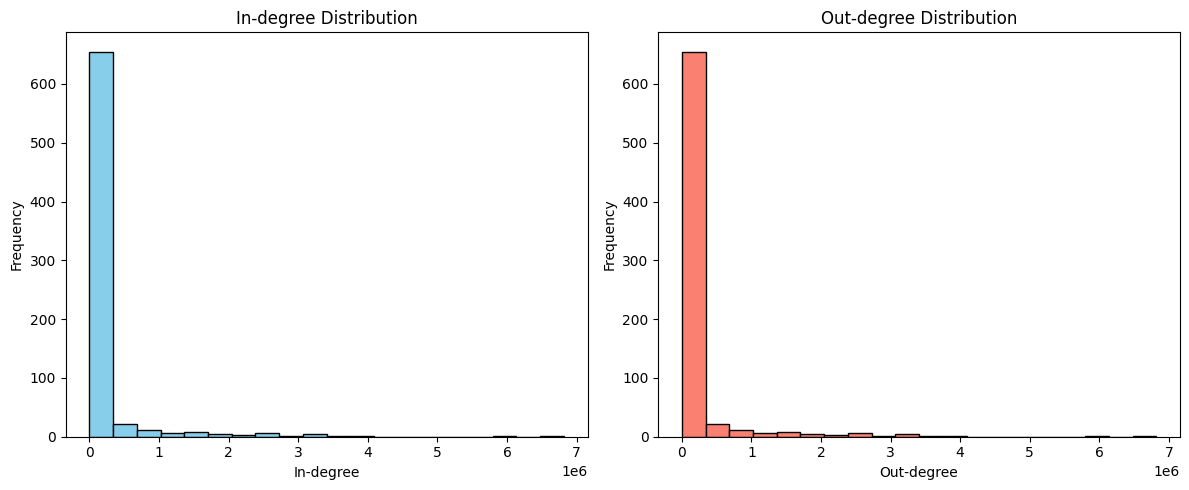

In [ ]:
summary = summarize_graph_features(adj_matrix_df)

### Compute total passenger flow between origin and destination cities.

In [ ]:
# Compute total passenger flow between origin and destination cities
total_passenger_flow = dataset.groupby('Route')['Passengers'].sum().reset_index()
total_passenger_flow = total_passenger_flow.sort_values(by="Passengers", ascending=False)
top_ten_passenger_flow = total_passenger_flow[:10]
top_ten_passenger_flow.head()

,Route,Passengers
7062,"(Dallas, TX, Houston, TX)",34571616
12292,"(Houston, TX, Dallas, TX)",34163023
16005,"(Los Angeles, CA, Honolulu, HI)",28963623
12166,"(Honolulu, HI, Los Angeles, CA)",28631618
15956,"(Los Angeles, CA, Chicago, IL)",26751937


### Identify and visualize the busiest routes by passenger traffic.

C:\Users\Paolo\AppData\Local\Temp\ipykernel_17456\3405876643.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_ten_passenger_flow['Route_str'] = top_ten_passenger_flow['Route'].apply(lambda x: f'{x[0]} -> {x[1]}')


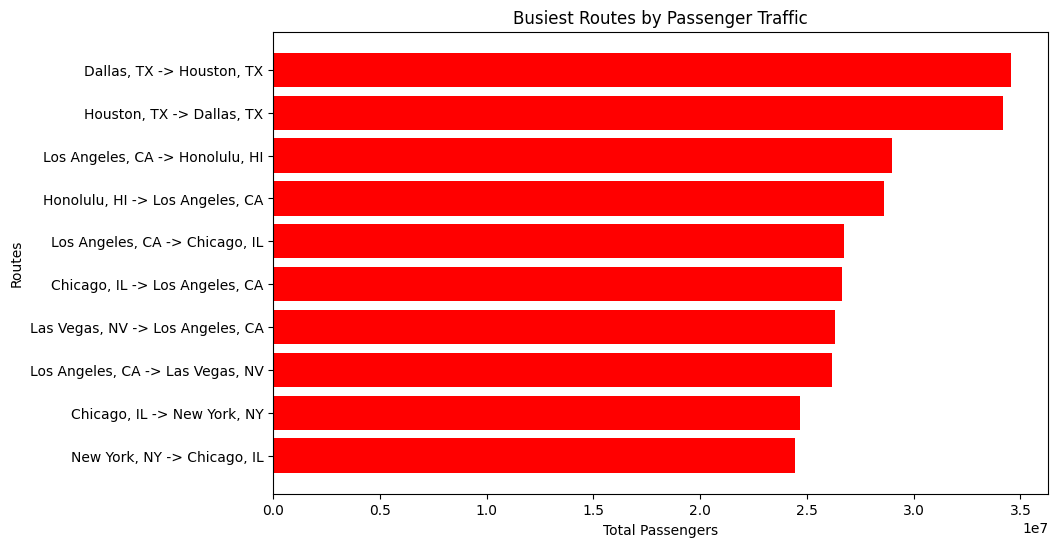

In [ ]:
# Visualize the busiest routes
plt.figure(figsize=(10, 6))
# Concatenate origin and destination from the 'Route' tuple for the y-axis labels
top_ten_passenger_flow['Route_str'] = top_ten_passenger_flow['Route'].apply(lambda x: f'{x[0]} -> {x[1]}')

plt.barh(top_ten_passenger_flow['Route_str'], top_ten_passenger_flow['Passengers'], color='red')
plt.xlabel('Total Passengers')
plt.ylabel('Routes')
plt.title('Busiest Routes by Passenger Traffic')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

### Calculate the average passengers per flight for each route and highlight under/over-utilized connections.

his code analyzes and visualizes the utilization of flight routes by filtering and categorizing them as over-utilized or under-utilized. 

1. **Filtering the Dataset**: 
   - Rows with *Passengers* > 0 are retained to exclude flights with no passengers.
   - Over-utilized routes are identified where *passengers_per_flight* exceeds *seats_per_flight*.
   - Under-utilized routes are identified where *passengers_per_flight* is less than 50% of *seats_per_flight*.

2. **Selecting Top Routes**: 
   - The top 15 over-utilized routes are selected based on the highest *passengers_per_flight*.
   - The top 15 under-utilized routes are selected based on the lowest *passengers_per_flight*.

3. **Visualization**:
   - A scatter plot is created for over-utilized routes, highlighting the excess demand (more passengers than available seats).
   - Another scatter plot visualizes under-utilized routes, where demand is significantly below seat capacity.

These plots annotate the airport pairs (routes) to help identify patterns or anomalies in utilization.

In [ ]:
dataset_filtered = dataset[dataset['Passengers'] > 0]
# Calculate over- and under-utilized routes (recalculate with the filtered dataset)
dataset_filtered['Over_Utilized'] = dataset_filtered['passengers_per_flight'] > dataset_filtered['seats_per_flight']
dataset_filtered['Under_Utilized'] = dataset_filtered['passengers_per_flight'] < (dataset_filtered['seats_per_flight'] * 0.5)

# Filter top over-utilized and under-utilized routes
top_over_utilized_filtered = dataset_filtered[dataset_filtered['Over_Utilized']] \
    .sort_values(by='passengers_per_flight', ascending=False).head(15)

top_under_utilized_filtered = dataset_filtered[dataset_filtered['Under_Utilized']] \
    .sort_values(by='passengers_per_flight', ascending=True).head(15)


C:\Users\Paolo\AppData\Local\Temp\ipykernel_17456\2732767232.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_filtered['Over_Utilized'] = dataset_filtered['passengers_per_flight'] > dataset_filtered['seats_per_flight']
C:\Users\Paolo\AppData\Local\Temp\ipykernel_17456\2732767232.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset_filtered['Under_Utilized'] = dataset_filtered['passengers_per_flight'] < (dataset_filtered['seats_per_flight'] * 0.5)


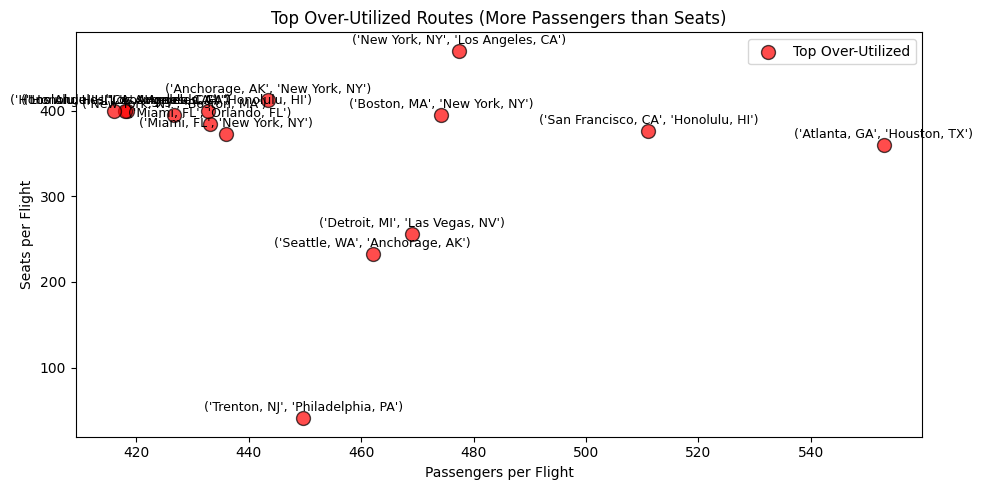

In [ ]:
# Plot for Over-Utilized Routes
plt.figure(figsize=(10, 5))
plt.scatter(top_over_utilized_filtered['passengers_per_flight'], top_over_utilized_filtered['seats_per_flight'],
            color='red', label='Top Over-Utilized', s=100, edgecolors='black', alpha=0.7)

# Annotate the over-utilized routes with their names (airport pairs)
for i, row in top_over_utilized_filtered.iterrows():
    plt.annotate(f"{row['Route']}", (row['passengers_per_flight'], row['seats_per_flight']),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=9, color='black')

# Labels and title for Over-Utilized
plt.xlabel('Passengers per Flight')
plt.ylabel('Seats per Flight')
plt.title('Top Over-Utilized Routes (More Passengers than Seats)')

# Show the Over-Utilized Plot
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Output the filtered top over-utilized and under-utilized routes
print("Top Over-Utilized Routes (More Passengers than Seats):")
top_over_utilized_filtered[['Route', 'passengers_per_flight', 'seats_per_flight']]

Top Over-Utilized Routes (More Passengers than Seats):


,Route,passengers_per_flight,seats_per_flight
1040966,"(Atlanta, GA, Houston, TX)",553.00,360.00
1639561,"(San Francisco, CA, Honolulu, HI)",511.08,376.00
2985789,"(New York, NY, Los Angeles, CA)",477.43,470.00
1689134,"(Boston, MA, New York, NY)",474.25,395.00
2165887,"(Detroit, MI, Las Vegas, NV)",469.00,256.00
1898495,"(Seattle, WA, Anchorage, AK)",462.00,233.00
3341600,"(Trenton, NJ, Philadelphia, PA)",449.67,40.67
1702454,"(Anchorage, AK, New York, NY)",443.36,412.00
1688751,"(Miami, FL, New York, NY)",436.00,373.00
1297639,"(Miami, FL, Orlando, FL)",433.00,384.00


In [ ]:
print("\nTop Under-Utilized Routes (Few Passengers relative to Seats):")
top_under_utilized_filtered[['Route', 'passengers_per_flight', 'seats_per_flight']]


Top Under-Utilized Routes (Few Passengers relative to Seats):


,Route,passengers_per_flight,seats_per_flight
3173737,"(Clarksburg, WV, Parkersburg, WV)",0.01,19.00
46113,"(Roswell, NM, Hobbs, NM)",0.02,19.00
1456975,"(Scranton, PA, Reading, PA)",0.02,19.00
46277,"(Brookings, SD, Huron, SD)",0.02,19.00
2940112,"(Kirksville, MO, Kansas City, MO)",0.02,19.00
3173723,"(Clarksburg, WV, Parkersburg, WV)",0.02,19.00
2558065,"(Sioux City, IA, Fort Dodge, IA)",0.02,19.00
3173756,"(Clarksburg, WV, Parkersburg, WV)",0.02,19.00
2139108,"(Ketchikan, AK, Ketchikan, AK)",0.02,10.00
3173735,"(Clarksburg, WV, Parkersburg, WV)",0.02,19.00


### Create an interactive map visualizing the geographic spread of the flight network.

In [ ]:
# hub_airports = summary['Hub Airports (90th Percentile Total Degree)']
# # Create an empty list to store the results
# hub_airport_data = []

# # Iterate over each airport code in hub_airports
# for airport in hub_airports:
#     # Find the city where the airport code matches either the origin or destination
#     city = dataset.loc[
#         (dataset['Origin_airport'] == airport) | (dataset['Destination_airport'] == airport),
#         ['Origin_city', 'Destination_city']
#     ].melt(value_name='City')['City'].dropna().unique()
    
#     # Ensure only unique matches are added
#     if len(city) > 0:
#         hub_airport_data.append({'Airport Code': airport, 'City': city[0]})

# # Create a DataFrame from the collected data
# hub_airports_df = pd.DataFrame(hub_airport_data)

# hub_airports_df.head()


In [ ]:
hub_airports_df = pd.read_csv("hub_airports.csv")
hub_airports_df.head()

,Airport Code,City,Latitude,Longitude
0,ABQ,"Albuquerque, NM",35.08,-106.65
1,ALB,"Albany, NY",42.65,-73.76
2,ANC,"Anchorage, AK",61.22,-149.90
3,ATL,"Atlanta, GA",33.75,-84.39
4,AUS,"Austin, TX",30.27,-97.74


In [ ]:
# # Create a map with Plotly, focusing on the United States
# fig = px.scatter_geo(hub_airports_df,
#                      lat='Latitude', 
#                      lon='Longitude', 
#                      text='City', 
#                      size='Degree', 
#                      title="Airport Hubs by Degree",
#                      hover_name='City', 
#                      size_max=7,
#                      color_continuous_scale='Viridis', 
#                      template="plotly", 
#                      opacity=0.6,
#                      scope='usa',  # Focus on the United States
#                      center={"lat": 37.0902, "lon": -95.7129})  # Center the map to the US

# # Show the map
# #fig.update_geos(showland=True, landcolor="#e3c69e")
# fig.update_geos(
#     showland=True,
#     landcolor="#e3c69e",  # Choose a light color for land
#     projection_type="albers usa",  # Projection for the United States
#     center={"lat": 37.0902, "lon": -95.7129},  # Center on the United States
#     fitbounds="locations"  # Fit bounds to the locations
# )
# fig.update_layout(
#     width=1200,  # Width of the map
#     height=800,  # Height of the map
# )
# fig.show()



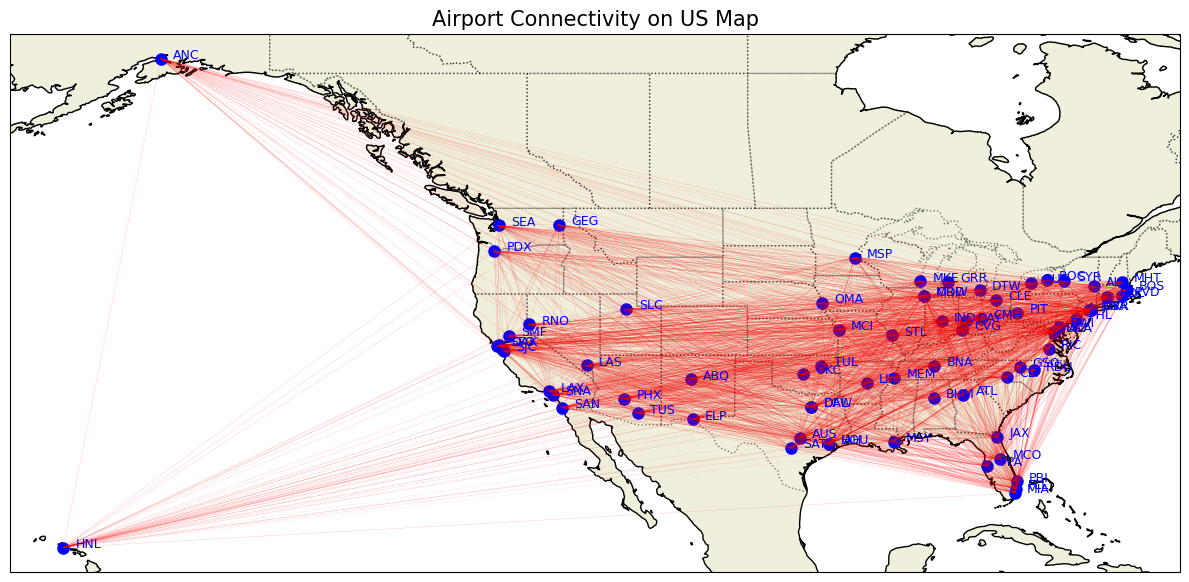

In [ ]:
# Initialize the map
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})
# ax.set_extent([-130, -60, 20, 55], crs=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.STATES, linestyle=':', alpha=0.5)

# Plot airports (nodes)
for i, row in hub_airports_df.iterrows():
    ax.plot(row['Longitude'], row['Latitude'], 'bo', markersize=8, transform=ccrs.PlateCarree())  # Blue dot for airport
    ax.text(row['Longitude'] + 1, row['Latitude'], row['Airport Code'], fontsize=9,
            transform=ccrs.PlateCarree(), color='blue')  # Label the airport

# Plot connections (edges)
for edge in G.edges():
    origin, destination = edge
    origin_coords = hub_airports_df[hub_airports_df['Airport Code'] == origin]
    dest_coords = hub_airports_df[hub_airports_df['Airport Code'] == destination]
    if not origin_coords.empty and not dest_coords.empty:
        x1, y1 = origin_coords['Longitude'].values[0], origin_coords['Latitude'].values[0]
        x2, y2 = dest_coords['Longitude'].values[0], dest_coords['Latitude'].values[0]
        ax.plot([x1, x2], [y1, y2], 'r-', linewidth=0.03, transform=ccrs.PlateCarree())  # Red line for connection

# Title and display
ax.set_title('Airport Connectivity on US Map', fontsize=15)
plt.tight_layout()
plt.show()


## **Q2. Node's Contribution (Q2)**

In any network, certain nodes (airports, in this case) play a critical role in maintaining connectivity and flow. Centrality measures are used to identify these nodes.

In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import cm
from matplotlib.colors import to_hex
from collections import Counter, defaultdict, deque
from queue import Queue
import heapq
import networkx as nx
from itertools import product
import re
from difflib import get_close_matches
import community as community_louvain
from pyspark.sql import SparkSession
from datetime import datetime
from functions import *

## 2.1 Implement a function *analyze_centrality(flight_network, airport)* that computes the following centrality measures for a given airport:
- Betweenness centrality: Measures how often a node appears on the shortest paths between other nodes.
- Closeness centrality: Measures how easily a node can access all other nodes in the network.
- Degree centrality: Simply counts the number of direct connections to the node.
- PageRank: Computes the "importance" of a node based on incoming connections and their weights.

### Adjacency list

It is better to represent a graph as an adjacency list. Then, created it as a dictionary in which each key is an airport, whose value is a list of all the directly reachable nodes from it. Since some of the airports only appeared as destinations we added them to the keys of the adjacency list and set their value to an empty list.

For this task the graph is considered as unweighted and directed, this is because computing centrality measures taking only in consideration the number of incoming and outgoing connections an airport has is sufficient to extract useful information from this data.

In [5]:
# Create the adjacency list with a defaultdict to handle missing airports
adjacency_list = defaultdict(list)

all_airports = set(dataset['Origin_airport']).union(dataset['Destination_airport'])

# Loop through each row in the dataframe to build the adjacency list
for _, row in dataset.iterrows():
    origin = row['Origin_airport']
    destination = row['Destination_airport']
    
    # Add the destination and distance to the origin airport'node adjacency list avoiding duplicates
    if destination not in adjacency_list[origin] and destination != origin:
        adjacency_list[origin].append(destination)
    
    # Ensure that the destination airport is also included as a key in the adjacency list with an empty list as value
    adjacency_list[destination]

### Betweenness Centrality

The **Betweenness Centrality** of a node $\mathit{v}$ is given by:

$$
\text{Betweenness}_{v} = \sum_{s\neq v\neq t}\frac{p_{st}(v)}{p_{st}}
$$

In which $\mathit{n}_{st}$ is the total number of shortest path between nodes $\mathit{s}$ and $\mathit{t}$, while $\mathit{p}_{st}(v)$ is the number of shortest paths between those two nodes that pass through $\mathit{v}$.


We can also normalize this value by dividing it by $\mathit{(N-1)(N-2)}$, where $\mathit{N}$ is the number of edges in the graph.

An high betweenness centrality means that a node is present in a lot of shortest path between two nodes, this implies that it can affect a lot of routes.
In our case study this means that an airport with high betweenness is intermediate in a lot of trail, meaning that in this airport a lot of people stopover to change flights.

Our function `betweenness_centrality(adjacency_list, airport=None, normalized=False)` computes the `airport`'s betweenness by computing all the shortest paths between all possible pairs of nodes using Breadth-First-Search (BFS), than counts all the shortest paths passing through `airport` and returns its betweenness value. If the parameter `airport` is `None` it computes all the betweenness values for all the nodes. Finally is `normalized` if `True` it returns the normalized betweenness. 

In [6]:
print(betweenness_centrality(adjacency_list, normalized=True))

{'MHK': 0.004874129108250289, 'AMW': 0.0, 'EUG': 0.001654048539012108, 'RDM': 0.0008451800090266171, 'MFR': 0.0010306469255607887, 'SEA': 0.016376532078849804, 'PDX': 0.014400273075086312, 'LMT': 0.00025033290406864387, 'SFO': 0.007140343031080286, 'LAX': 0.01398683656135929, 'EAT': 0.000206990011629147, 'YKM': 0.00099398218822466, 'EKO': 0.006440206543624893, 'SLE': 3.9108781013586566e-05, 'GEG': 0.008661337129340656, 'RDD': 0.0012768236261950809, 'LWS': 0.0012036059398247425, 'AST': 0.0, 'CLM': 0.00014952841042238383, 'PDT': 0.00036907107508295315, 'SJC': 0.004305433873419563, 'ACV': 0.0003990036711450722, 'PUW': 0.0005119332206983501, 'SMF': 0.008006846968263833, 'FLL': 0.005493170313119849, 'PHX': 0.015650469212760844, 'BFI': 0.012820625283671136, 'GGG': 0.0005268705691301064, 'GTF': 0.005601928795246705, 'FAT': 0.002748508142976187, 'TUS': 0.017892015663479477, 'MWH': 0.0010986691191765536, 'BIL': 0.00409979154175786, 'DFW': 0.019666883540866806, 'RBG': 0.0, 'SLC': 0.0153017858108

### Closeness Centrality

**Closeness Centrality** of a node $\mathit{v}$ is defined as the reciprocal of the sum of the distances between the node and every other node in the graph:

$$
\text{Closeness}_{v} = \frac{1}{\sum_{w}d(v, w)}
$$

In which $\mathit{d}(v, w)$ is the length of the shortest path between $\mathit{v}$ and $\mathit{w}$. Since in our case the graph is not weighted this value is equal to the number of edges that form the shortest path between the two nodes.

This value can be normalize by dividing it by $\frac{1}{\mathit{N-1}}$, that is equivalent to multiply it by $\mathit{(N-1)}$.

A normalized closeness centrality represents the average length of the shortest path that starts in $\mathit{v}$. This means that an airport that as a closeness centrality equal to $\mathit{c}$, on average, reaches every other airport stopping $\mathit{c}$ times.

Our `closeness_centrality(adjacency_list, airport, normalized=False)` firstly computes, using BFS, all the shortest paths from `airport` to every different node in the graph and stores the distances in a list, then, if `normalized=True` it returns the normalized closeness centrality of the airport, otherwise it returns its absolute closeness.

In [7]:
print(closeness_centrality(adjacency_list, 'ORD', normalized=True))

0.6185476815398075


### Degree Centrality

The **Degree Centrality** of a node is defined as the number of nodes that are incident to it. This can be even normalized by dividing its value by $\mathit{(N-1)}$.

Since we're dealing with a directed graph we can split it in two chunks:

- The **In-degree** centrality, that measures the number of incoming edges in the node;
- The **Out-degree** centrality, that measures the number of edges coming out of the node.

This evidently denotes the fact that an airport with a large in-degree value has a lot of arrivals, while one with large out-degree value has many departures.
A large **total degree centrality** denotes an airport with a lot of air traffic.

Our `degree_centrality(adjacency_list, airport, normalized=False, tot=False)` function computes an airport's normalized in-degree and out-degree centralities if `normalized=True`, while if `tot=True` it computes the total degree centrality of the node.

In [8]:
print(degree_centrality(adjacency_list, 'ORD', normalized=True, tot=True))

0.72


### PageRank

**PageRank** is an algorithm that assigns to each node $\mathit{v}$ of a graph a numerical weight $\mathit{PR(v)}$ linked to the relative importance of the node in the graph.

In our case, this value represents the likelihood that a person randomly traveling will arrive at the airport $\mathit{v}$.

Our `analyze_centrality(adjacency_list, airport, damp=0.85, epsilon=1e-3)` function firstly initializes $\mathit{PR(v)}=\frac{1}{N}$ for each node in the graph, sets `diff` to `inf` and computes the in-degree and the out-degree of each node. Then, while `diff` is bigger then a certain threshold `epsilon`, it iterates through each node computing its raw rank as $PR_{temp}=\sum_{n\in M}\frac{1}{{OutDegrees}_n}\times PR(n)$, then computing its final rank as $PR = \frac{(1-damp)}{N}+(damp\times PR_{temp})$ and updating the $\mathit{PR}$ of each node, in which $\mathit{M}$ is a set containing all the neighbors of $\mathit{v}$. Then `diff` is updated as the sum of the absolute values of the  differences between each node $\mathit{PR}$ and its $\mathit{PR}$ computed in the previous iteration.

In [9]:
print(pagerank(adjacency_list, 'ORD'))

0.0052417186987570195


### Finally `analyze_centrality(flight_network, airport)`

`analyze_centrality(flight_network, airport)` returns all the above-mentioned, normalized and not normalized, centrality measures for the node `airport`.

In [10]:
analyze_centrality(adjacency_list, 'ORD')

ORD's betweenness centrality is 8205.705657425731

ORD's normalized betweenness centrality is 0.015589827410327219

ORD's closeness centrality is 0.0008748906386701663

ORD's normalized closeness centrality is 0.6185476815398075

ORD's in-degree centrality is 239

ORD's out-degree centrality is 285

ORD's total degree centrality is 524

ORD's total normalized degree centrality is 0.72

ORD's PageRank score is 0.0052417186987570195


## 2.2 Write a function `compare_centralities(flight_network)` to:

   - Compute and compare centrality values for all nodes in the graph.
   - Plot centrality distributions (histograms for each centrality measure).
   - Return the top 5 airports for each centrality measure.

From the plots below we can see that most of the airports have a low **betweenness** centrality, this means that almost all the flights are direct and because of this the **closeness** is low for many airports.

We can also observe that the **In-degree** and **Out-degree** follow very similar distributions and that several airports have a low **PageRank** score.

We can also notice that for all the centrality measures we have that **YIP**, **MSP** and **MEM** are always in the top 5 highest scores, meaning that Detroit, Minneapolis and Memphis are cities with and high air traffic.

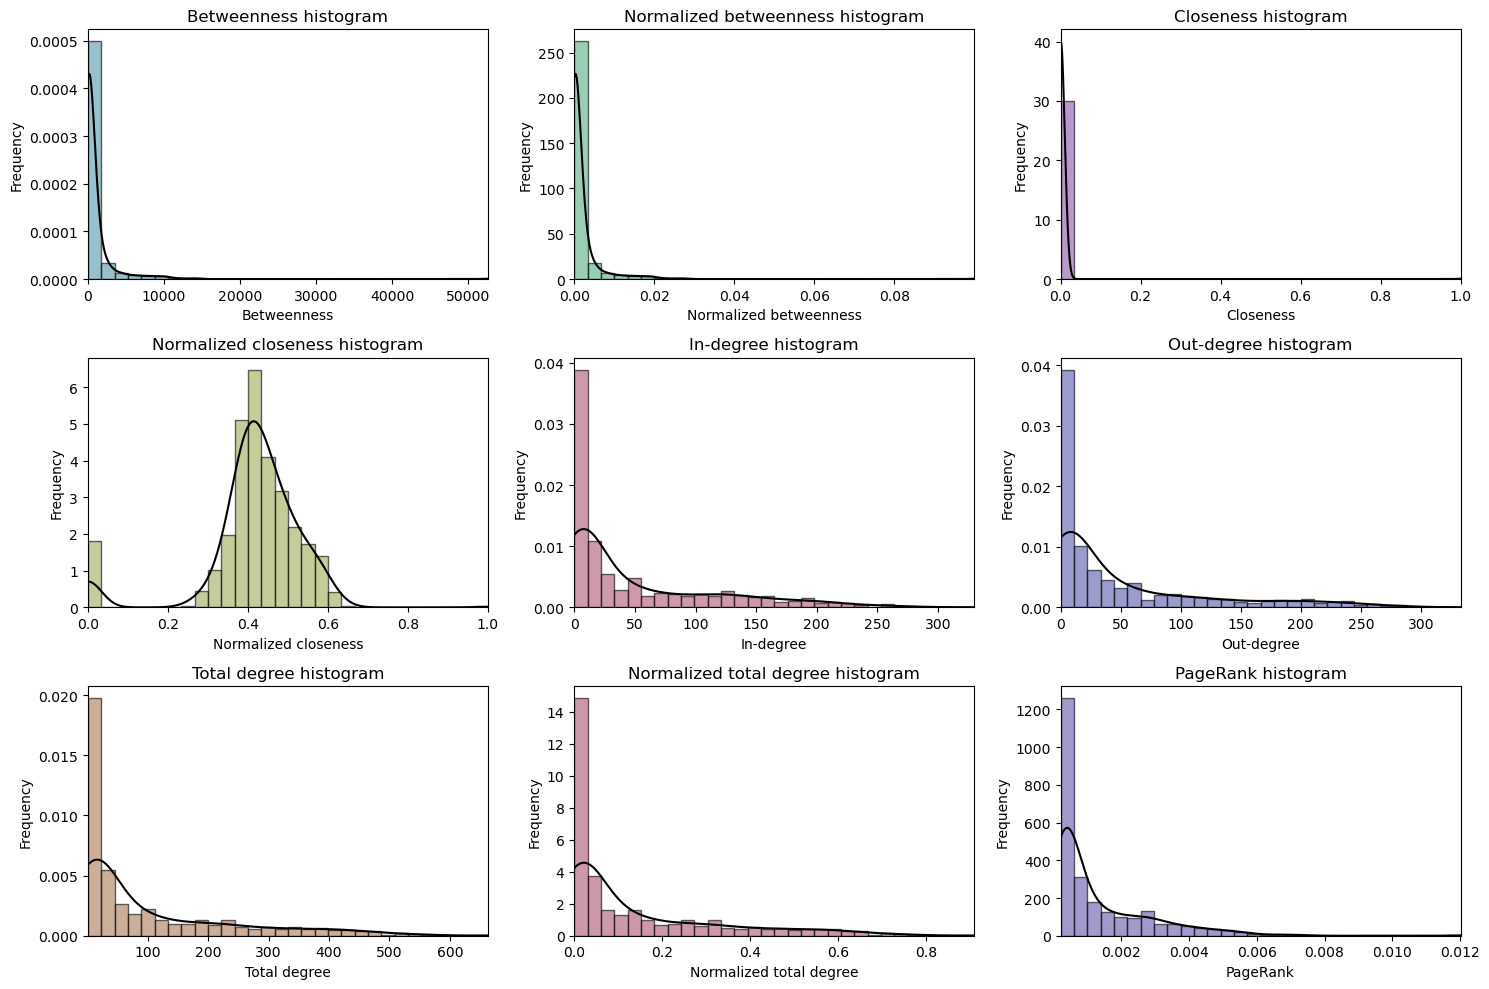

Top 5 airports by 'Betweenness':
Airport: YIP, Betweenness: 52603.18257089174
Airport: MSP, Betweenness: 14487.528981445212
Airport: MEM, Betweenness: 13945.493158175286
Airport: MCI, Betweenness: 12550.742966407006
Airport: SHV, Betweenness: 11624.725433715792
________________________________________
Top 5 airports by 'Normalized betweenness':
Airport: YIP, Normalized betweenness: 0.0999395508138914
Airport: MSP, Normalized betweenness: 0.027524515971207773
Airport: MEM, Normalized betweenness: 0.02649471484406818
Airport: MCI, Normalized betweenness: 0.023844861720161502
Airport: SHV, Normalized betweenness: 0.022085542763780358
________________________________________
Top 5 airports by 'Closeness':
Airport: FVS, Closeness: 1.0
Airport: YIP, Closeness: 0.0009099181073703367
Airport: MSP, Closeness: 0.000881057268722467
Airport: MEM, Closeness: 0.0008756567425569177
Airport: ORD, Closeness: 0.0008748906386701663
________________________________________
Top 5 airports by 'Normalized cl

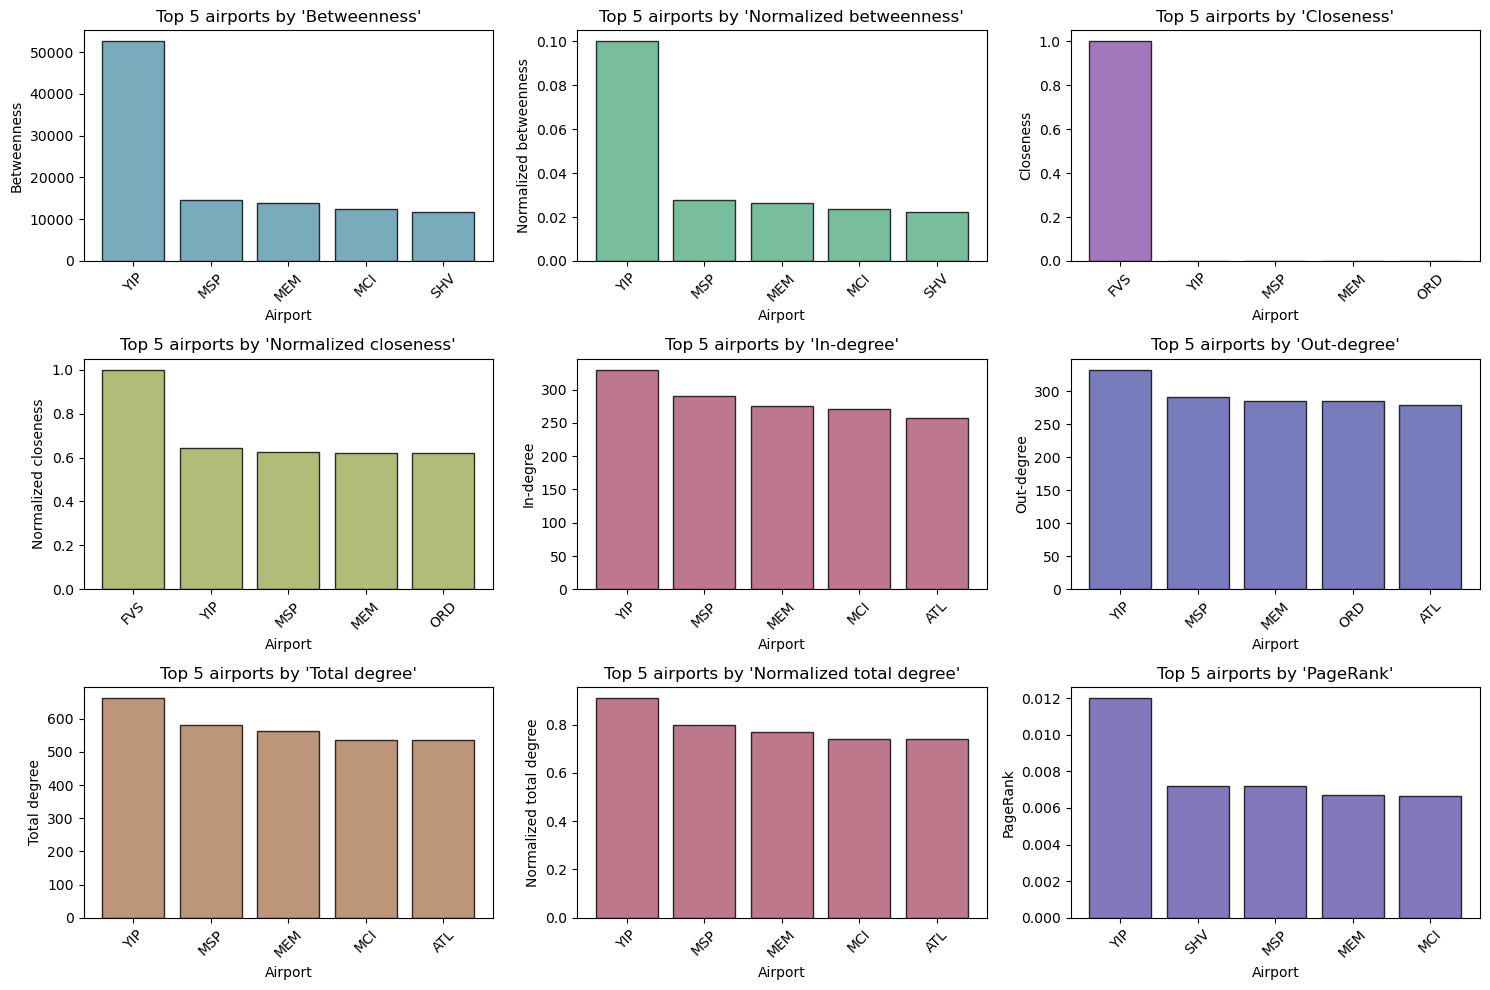

None


In [11]:
print(compare_centralities(adjacency_list, n=5))

## 2.3 Ask LLM (eg. ChatGPT) to suggest alternative centrality measures that might be relevant to this task. How can you check that the results given by the LLM are trustable?

### **Prompt**: 
Can you suggest me an alternative centrality measure that might be relevant for a directed unweighted graph that represent airplanes routes from airport to airport.
Avoid betweenness, closeness, degree and pagerank.

### **Answer**

For a directed, unweighted graph representing airplane routes between airports, an alternative centrality measure that might be relevant is Katz centrality. Here's why it fits your use case:

**Katz Centrality**

   - What it is: Katz centrality considers not only the immediate neighbors (as in degree centrality) but also the influence of more distant nodes. It assigns a score to each node based on the number and length of walks leading to it, with longer walks contributing less to the score.
   - Why relevant for flight routes: Airports with many indirect connections might still be significant even if they aren't directly well-connected. Katz centrality captures this by considering the cumulative effect of connections through intermediate airports.
   - Customization for your graph: You can adjust the decay factor to control how much influence distant airports (via longer routes) have on the centrality score.

Other Considerations

   - Hubs and Authorities (HITS algorithm):
       - What it is: This measure distinguishes between "hub" nodes (airports that lead to important airports) and "authority" nodes (airports that are destinations of important hubs).
       - Why relevant: It can highlight airports that serve as major departure points (hubs) and those that are prominent destinations (authorities).

   - Eigenvector Centrality:
       - What it is: A measure where a node's centrality is proportional to the centrality of its neighbors. It is similar to Katz centrality but focuses only on direct connections.
       - Why relevant: It emphasizes airports that are connected to other highly connected airports, which might indicate network hubs.

   - Flow Betweenness Centrality:
       - What it is: A variation of betweenness centrality that considers the flow of information or traffic in the network.
       - Why relevant: For air traffic networks, it might help identify critical airports for the efficient flow of flights between regions.

Each of these measures provides different insights into the importance of nodes in your directed, unweighted graph. Katz centrality or HITS might be particularly insightful for understanding the layered importance of airports.

-------------------------------------------------------------

To check if the results given by the LLM are trustable, I could firstly look if these measures actually exist and if the descriptions and definitions found in other sources match the ones given by the LLM. Secondly, I could check for articles relative to flight network analysis and see if these measures are actually pertinent to the study of this topic.

## 2.4 Implement one of these measures suggested by the LLM, compare its results to the centralities you've already computed, and analyze whether it adds any new insights.

### Hyperlink-Induced Topic Search

**Hyperlink-Induced Topic Search** (**HITS**) (also known as **Hubs and Authorities**) is a link analysis algorithm, like PageRank it's mostly used in analyzing web pages networks.

This algorithm computes two values for a node:

- **Authority** that measures the value of the node in the graph;
- **Hub** that measures the importance of a node's links to other nodes.

Our `hits(adjacency, airport=None, max_iter=1000, epsilon=1e-6)` computes HITS values for each node in the graph if an `airport` is not specified, otherwise it computes the input `airport`'s authority and hub value.

Initially, the function sets each node's $\mathit{authority}$ and $\mathit{hub}$ to 1, then, for each iteration it computes each node $\mathit{authority}$ as the sum of each of it's neighbors' $\mathit{hub}$, later this $\mathit{authority}$ is normalized by dividing it by its euclidean.
The $\mathit{hub}$ value is computed in an analogous way: it is the sum of the node's neighbors' $\mathit{authority}$, then it is normalized by dividing it by it's euclidean norm. The algorithm stops if the difference between two consecutive iteration $\mathit{authority}$ and $\mathit{hub}$ is smaller than a certain tolerance `epsilon` or if the maximum number iterations is reached.

In our case, an airport with an high $\mathit{authority}$ is the destination to a lot of flights, hence it could be a really touristic city, while an high $\mathit{hub}$ value means that the airport has a lot of departures, so it could be an highly populated city airport.

In [12]:
print(hits(adjacency_list, 'ORD'))

(0.09710573478472825, 0.10724583085715206)


In [13]:
data_hits = {'Airport': adjacency_list.keys(), 'Auth':list(hits(adjacency_list)[0].values()), 'Hubs':list(hits(adjacency_list)[1].values())}

hits_df = pd.DataFrame.from_dict(data_hits)

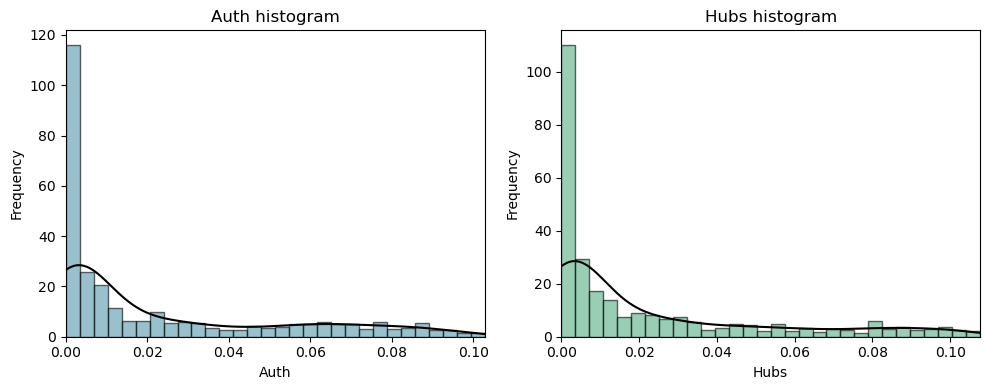

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))


colors = ['#5698ad', '#56ad83']
    
# Loop over columns in the DataFrame starting from the second column
for i, column in enumerate(hits_df.columns[1:]):
    data = hits_df[column].dropna()
        
    axs[i].hist(data, bins=30, color=colors[i], edgecolor='black', density=True, alpha=0.6)

    data = hits_df[column].dropna()
    kde = gaussian_kde(data)
    x = np.linspace(data.min(), data.max(), 500)
    axs[i].plot(x, kde(x), color='black', linestyle='-', linewidth=1.5, label='Density Curve')

    axs[i].set_title(f'{column} histogram')
    axs[i].set_xlabel(column)
    axs[i].set_ylabel('Frequency')
    axs[i].set_xlim(data.min(), data.max())

plt.tight_layout()

plt.show()

We can observe that the distribution of the $\mathit{authority}$ and the one of $\mathit{hubs}$ are similar and they resemble the distribution of the **degree** centrality.

In our case, both the $\mathit{authority}$ and the $\mathit{hubs}$ values are closer to 0 than they are to 1.

Top 5 airports by 'Auth':
Airport: MSP, Auth: 0.10279798560953221
Airport: MEM, Auth: 0.10196215536592686
Airport: ATL, Auth: 0.10025352661902026
Airport: IND, Auth: 0.10007592852661394
Airport: STL, Auth: 0.09935964721491682
________________________________________
Top 5 airports by 'Hubs':
Airport: MSP, Hubs: 0.10764476251801561
Airport: ORD, Hubs: 0.10724583085715206
Airport: ATL, Hubs: 0.10618020238232237
Airport: MEM, Hubs: 0.10540625155536494
Airport: STL, Hubs: 0.10449984754104837
________________________________________


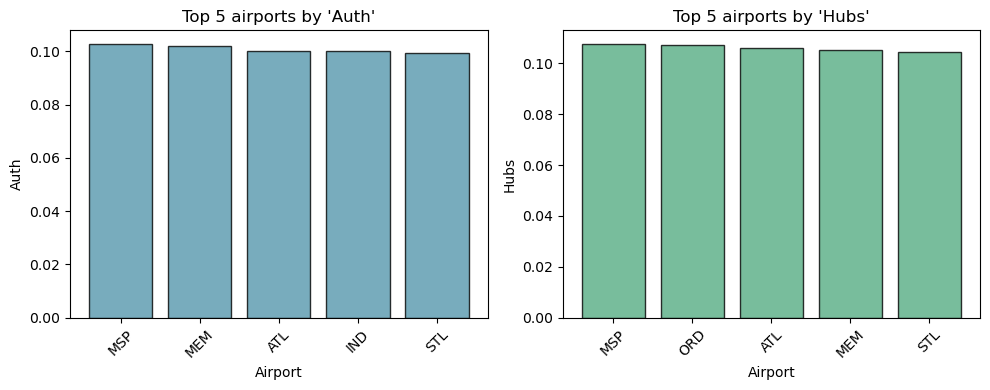

In [15]:
numeric_columns = hits_df.select_dtypes(include=[np.number]).columns
    
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

colors = ['#5698ad', '#56ad83']

for i, column in enumerate(numeric_columns):
    # Sort the DataFrame by the current column
    top = hits_df.nlargest(5, column)
        
    # Extract IDs and their corresponding values
    ids = top.iloc[:, 0] 
    values = top[column]
        
    # Print the top IDs and values
    print(f"Top {5} airports by '{column}':")
    for idx, value in zip(ids, values):
        print(f"Airport: {idx}, {column}: {value}")
    print("_" * 40)
        
    # Plot the bar chart
    axs[i].bar(ids, values, color=colors[i], alpha=0.8, edgecolor='black')
    axs[i].set_title(f"Top {5} airports by '{column}'", fontsize=12)
    axs[i].set_xlabel('Airport', fontsize=10)
    axs[i].set_ylabel(column, fontsize=10)
    axs[i].tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

Looking at the top 5 airports by $\mathit{autority}$ and by $\mathit{hub}$, we can see that most of them are the same that have high centralities. One big difference is the absence of **YIP**.

We can also notice that **STL** has an high $\mathit{autority}$ and an high $\mathit{hub}$.

In [16]:
print(analyze_centrality(adjacency_list, 'ORD', plus=True))

ORD's betweenness centrality is 8205.705657425731

ORD's normalized betweenness centrality is 0.015589827410327219

ORD's closeness centrality is 0.0008748906386701663

ORD's normalized closeness centrality is 0.6185476815398075

ORD's in-degree centrality is 239

ORD's out-degree centrality is 285

ORD's total degree centrality is 524

ORD's total normalized degree centrality is 0.72

ORD's PageRank score is 0.0052417186987570195

ORD's Authority score is 0.09710573478472825 and its Hub score is 0.10724583085715206
None


## **3. Finding Best Routes (Q3)**
Whenever you plan to fly to a specific city, your goal is to find the most efficient and fastest flight to reach your destination. In the system you are designing, the best route is defined as the one that minimizes the total distance flown to the greatest extent possible.

In this task, you need to implement a function that, given an origin and destination city, determines the best possible route between them. To simplify, the focus will be limited to flights operating on a specific day.
Note: Each city may have multiple airports; in such cases, the function should calculate the best route for every possible airport pair between the two cities. For example, if city 
A
 has airports 
a
1
,
a
2
 and city B has 
b
1
,
b
2
, the function should compute the best routes for 
a
1
→
b
1
, 
a
1
→
b
2
, 
a
2
→
b
1
 and 
a
2
→
b
2
. If it’s not possible to travel from one airport in the origin city to another airport in the destination city on that date, you must report it as well.

The function takes the following inputs:

Flights network
Origin city name
Destination city name
Considered Date (in yyyy-mm-dd format)
The function output:

A table with three columns: 'Origin_city_airport', 'Destination_city_airport', and the 'Best_route'.
Note: In the "Best_route" column, we expect a list of airport names connected by 
→
, showing the order in which they are to be visited during the optimal route. If no such route exists, the entry should display "No route found."



# Code Analysis: Finding the Best Flight Routes

This code identifies the best flight routes between two cities specified by the user, using a flight dataset. It provides functionality for cleaning city names, matching them against available data, and constructing a graph to calculate optimal routes between airports.

---

## Key Features

### 1. **City Name Cleaning and Normalization**
The `clean_city_input` function preprocesses city names by:
- Removing state information (e.g., ", TX").
- Removing content inside parentheses.
- Converting the name to lowercase and stripping extra spaces.

This ensures more robust matching of city names with the dataset.

---

### 2. **Robust City Matching**
The `match_city` function maps user-input city names to dataset entries. It:
- Cleans the input city name using `clean_city_input`.
- Attempts an exact match against preprocessed city names.
- Uses `difflib.get_close_matches` to find the closest partial match if no exact match is found.

If no match is found, the function returns `None`.

---

### 3. **Filtering Flights by Date**
The `find_best_routes` function filters flights based on the specified travel date:
- If no flights are available on the chosen date, it searches for the closest alternative dates (before or after) and suggests them to the user.

---

### 4. **City-to-Airport Mapping**
The code creates a mapping of cities to their respective airports using the filtered dataset. This mapping is crucial for connecting cities to the flight graph.

---

### 5. **Flight Graph Construction**
A directed graph is built using the `networkx` library. 
- Each airport is represented as a node.
- Flight connections between airports are represented as weighted edges, where the weight corresponds to the flight distance.

---

### 6. **Optimal Route Calculation**
The function calculates the best routes between airports:
- It generates all possible airport-to-airport pairs between the origin and destination cities.
- For each pair, it uses `networkx.shortest_path` to find the shortest path based on flight distance.
- If no path exists, it records this in the results.

The results are returned as a DataFrame, showing the origin and destination airports and the best route.

---

## Algorithms and Libraries

1. **String Matching**:
   - Uses `difflib.get_close_matches` to perform fuzzy matching for city names, identifying the closest match when an exact match is unavailable.

2. **Graph Algorithms**:
   - Leverages Dijkstra's algorithm (via `networkx.shortest_path`) to calculate the shortest path between airports based on flight distance.

3. **Pandas**:
   - Utilized for data manipulation and filtering.

4. **NetworkX**:
   - Used for creating and analyzing the flight graph.

---

## Example Workflow
1. **User Input**:
   - The user provides the origin city, destination city, and flight date.
   
2. **City Matching**:
   - The input cities are cleaned and matched to the dataset.

3. **Flight Filtering**:
   - Flights are filtered by date, and alternative dates are suggested if necessary.

4. **Route Calculation**:
   - The code computes the shortest routes between the airports of the matched cities.

5. **Output**:
   - A DataFrame displaying the best routes is returned and printed.

---

## Error Handling
- Handles cases where:
  - No flights are available on the specified date.
  - The input cities do not match any city in the dataset.
  - No route exists between the airports.



In [ ]:
# User input
origin_city = input("Enter the origin city: ").strip()
destination_city = input("Enter the destination city: ").strip()
fly_date = input("Enter the flight date (yyyy-mm-dd): ").strip()

# Normalize cities in the DataFrame
df = dataset.assign(
    Origin_city_clean=dataset['Origin_city'].apply(clean_city_input),
    Destination_city_clean=dataset['Destination_city'].apply(clean_city_input)
)

# Match cities with the dataset
matched_origin = match_city(origin_city, df['Origin_city_clean'].unique())
matched_destination = match_city(destination_city, df['Destination_city_clean'].unique())

# Diagnostics
if matched_origin:
    print(f"The origin city '{origin_city}' is valid. Match found: '{matched_origin}'")
else:
    print(f"Error: The origin city '{origin_city}' is not in the dataset.")

if matched_destination:
    print(f"The destination city '{destination_city}' is valid. Match found: '{matched_destination}'")
else:
    print(f"Error: The destination city '{destination_city}' is not in the dataset.")

# If both cities are valid, run the function
if matched_origin and matched_destination:
    best_routes_df = find_best_routes(df, matched_origin, matched_destination, fly_date)

    # Display the result
    if not best_routes_df.empty:
        print(best_routes_df)
    else:
        print("No results found for the provided combination.")
else:
    print("Check the city names and try again.")


Enter the origin city:  chicago
Enter the destination city:  washington
Enter the flight date (yyyy-mm-dd):  2003-08-23
The origin city 'chicago' is valid. Match found: 'chicago'
The destination city 'washington' is valid. Match found: 'washington'
Error: No flights are available for the date 2003-08-23. Searching for alternative dates...
We suggest the next closest alternative date: 2003-09-01
  Origin_city_airport Destination_city_airport       Best_route
0                 ORD                      IAD        ORD → IAD
1                 ORD                      DCA        ORD → DCA
2                 MDW                      IAD  MDW → CMH → IAD
3                 MDW                      DCA        MDW → DCA
4                 PWK                      IAD  PWK → CLE → IAD
5                 PWK                      DCA  PWK → CLE → DCA
6                 DPA                      IAD  DPA → SYR → IAD
7                 DPA                      DCA  DPA → SYR → DCA


## **4. Airline Network Partitioning (Q4)**

Imagine all these flights are currently managed by a single airline. However, this airline is facing bankruptcy and plans to transfer the management of part of its operations to a different airline. The airline is willing to divide the flight network into two distinct partitions, $p_1 $and 
p
2
, such that no flights connect any airport in 
p
1
 to any airport in 
p
2
. The flights in 
p
1
 will remain under the management of the original airline, while those in 
p
2
 will be handed over to the second airline. Any remaining flights needed to connect these two partitions will be determined later.

In graph theory, this task is known as a graph disconnection problem. Your goal is to write a function that removes the minimum number of flights between airports to separate the original flight network into two disconnected subgraphs.
The function takes the following inputs:

1. Flight network

   
The function outputs:

1. The flights removed to disconnect the graph.
2. Visualize the original flight network.
3. Visualize the graph after removing the connections and highlight the two resulting subgraphs.
Note: In this task, airline only concerned with the flights between airports, and the flight times are not relevant.

In [ ]:
# Drop rows with missing values in key columns
df_cleaned = dataset.dropna(subset=['Origin_airport', 'Destination_airport'])

# Remove duplicate rows
df_cleaned = df_cleaned.drop_duplicates()

# Confirm cleaning results
print("After cleaning:")
print(f"Number of rows: {len(df_cleaned)}")
print(f"Columns: {df_cleaned.columns}")

After cleaning:
Number of rows: 3565050
Columns: Index(['Origin_airport', 'Destination_airport', 'Origin_city',
       'Destination_city', 'Passengers', 'Seats', 'Flights', 'Distance',
       'Fly_date', 'Origin_population', 'Destination_population',
       'Org_airport_lat', 'Org_airport_long', 'Dest_airport_lat',
       'Dest_airport_long'],
      dtype='object')


* *Around 41,753 rows were deleted, to avoid wrong information*

In [ ]:
# necessary columns for graph construction
graph_data = df_cleaned[['Origin_airport', 'Destination_airport']].copy()

# preview of the prepared data
print("Prepared Data for Graph Construction:")
print(graph_data.head())

Prepared Data for Graph Construction:
  Origin_airport Destination_airport
0            MHK                 AMW
1            EUG                 RDM
2            EUG                 RDM
3            EUG                 RDM
4            MFR                 RDM


**Minimum Cut for Graph Disconnection**

The goal of the minimum cut is to disconnect the graph by removing the smallest possible number of edges (flights). Mathematically, this approach ensures that the graph is split into two distinct subgraphs, p1 and p2, where no edges connect the nodes in p1 with the nodes in p2.

In general, the function is build this way: 

**1. Graph:**
   - Nodes represent airports (Origin_airport and Destination_airport).
   - Edges represent flights between airports, and we assign a fixed weight (capacity=1) to each edge.

**2. Source and Sink Nodes for the min cut calculation:**
- A source node (first airport in the dataset)sink n.
- A sink node (last airport in the dataset) are chosen.

**3. Minimum Cut Calculation:**

- The nx.minimum_cut function is applied to identify the smallest set of edges (flights) whose removal disconnects the graph.

**4. Removed flights (edges):**

- The function prints the flights that were removed to achieve the disconnection.
Graph Visualization:

**5. Graph visual:**

- Original Flight Network: A visualization of the entire graph before disconnection.

- Disconnected Graph: A visualization of the graph after removing the identified edges, highlighting the two resulting subgraphs:
* Nodes in Partition 1 are green.
* Nodes in Partition 2 are yellow.

Minimum Cut Value (number of edges removed): 1
Flights (Edges) removed to disconnect the graph:
('YIP', 'PHD')


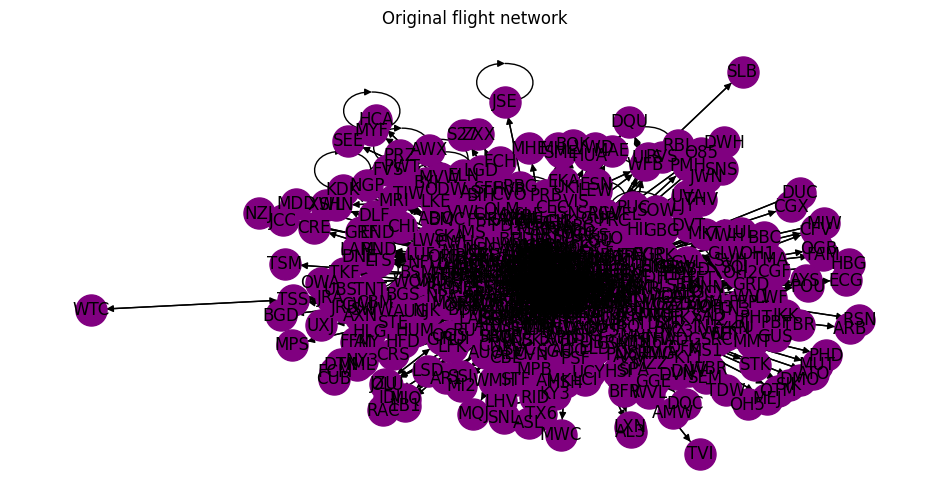

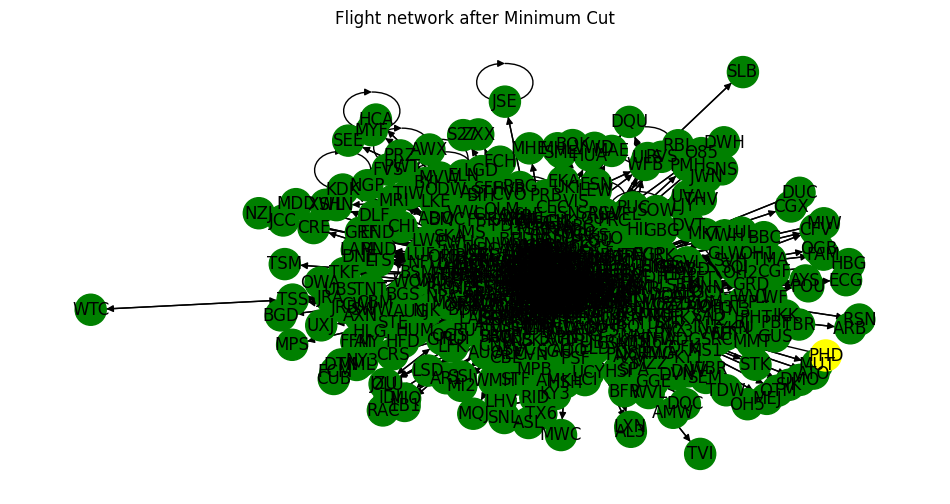

In [ ]:
airline_partitioning(graph_data)

**Result:** the function only removed 1 flight. So, few edges were removed which can mean that the network has bridge edges, where single conections are  critical to manintain  conectivity or the graph is highly conected but specific weak points exists.

To address this issue, balanced partitioning approach is needed. This method aims to divide the flight network into two approximately equal-sized partitions, minimizing the number of edges (routes) between the two groups. This approach better reflects the real-world scenario where the two new airlines would want to share the routes of the original airline as evenly as possible.

By achieving a more balanced division, we ensure that:

* Both airlines receive a fair share of the flight network as the division is both mathematically valid and practically meaningful.

For this, we use a graph partitioning method called the Kernighan-Lin algorithm, where the nx.community.kernighan_lin_bisection function is used to split the graph into two partitions of approximately equal size, while minimizing the number of edges (routes) between them.

Regarding the graph:

 Nodes are colored based on their partition:
* Green for Partition 1.
* Yellow for Partition 2.
* The edges connecting the two partitions are highlighted in red to show the cut.

Balanced Partition Results:
Number of nodes in Partition 1: 363
Number of nodes in Partition 2: 364
Number of edges between partitions: 2268


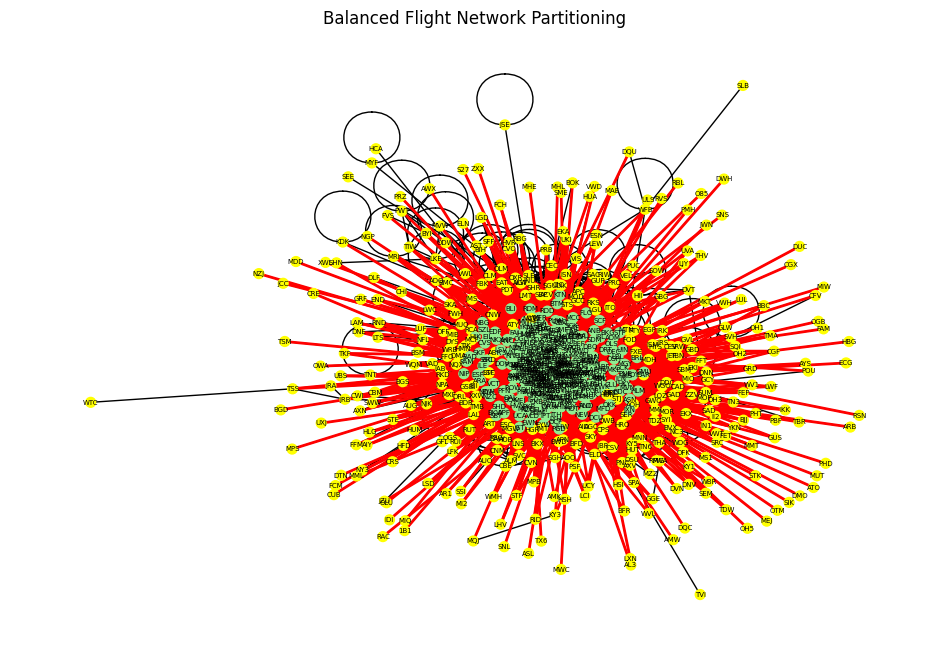

In [ ]:
balance_partitioning(graph_data)

**Result:** we got a better graph result, meaning that if the two airlines have similar operational capacities, this solution will be optimal for splitting the airlin'es flight network. Also, we are able to see that there is a concentration of the green color, so maybe that airline can focus in a more close area, while the other airline can do more peripheral area. Blanced partitiones helped to show a logical and functional solution for solving this problem for the two airlines.

# **5. Finding and Extracting Communities (Q5)**
Airlines can optimize their operations by identifying communities within a flight network. These communities represent groups of airports with strong connections, helping airlines pinpoint high-demand regions for expansion or underserved areas for consolidation. By analyzing these communities, airlines can improve resource allocation, reduce costs, and enhance service quality.

In this task, you are asked to analyze the graph and identify the communities based on the flight network provided. For the airline, the primary focus is on the cities, so your communities should reflect the connectivity between cities through the flights that link them.
The function takes the following inputs:

- Flight network

- A city name $\mathit{c_1}$

- A city name $\mathit{c_2}$


The function outputs:

- The total number of communities and the cities that belong to each community
- Visualize the graph highlighting the communities within the network (each community with different color)
- If city $\mathit{c_1}$ and $\mathit{c_2}$ belong to the same community or not

Ask a LLM (ChatGPT, Claude AI, Gemini, Perplexity, etc.) to suggest an alternative algorithm for extracting communities and explain the steps required to implement it. Then, implement this algorithm and compare its results with the current method you've chosen. Discuss the differences in the outcomes and analyze which approach you think is better, providing reasons for your choice.


# Community Detection in Airport Network: Louvain Algorithm

This Python script demonstrates the use of the **Louvain algorithm** to detect communities in a network of airports in the United States. The dataset contains information on flights between airports, including the number of flights, passengers, and distances between cities. 

The primary steps involved are:

1. **Data Preprocessing**: The dataset is filtered to include only significant flight routes (with a minimum of 250 flights, 100 passengers, and a distance of at least 70 miles).
2. **Network Creation**: A graph is created where each node represents an airport (city), and each edge represents a flight route between two airports.
3. **Community Detection**: The Louvain algorithm is applied to detect communities within the airport network. This algorithm aims to partition the network into groups of airports (communities) that are more densely connected to each other than to airports in other communities.
4. **Visualization**: The graph is visualized with nodes colored by their community and sized based on their **degree centrality** (a measure of the importance of a node within the network). The nodes are labeled with the airport names.
5. **User Interaction**: The script includes a feature where the user can input two cities and check if they belong to the same community based on the Louvain partitioning.

## Key Features of the Script:
- **Community Detection**: Using the Louvain method to identify clusters of airports.
- **Graph Visualization**: Displaying the network with nodes sized according to their importance (degree centrality) and colored based on the communities detected.
- **User Input**: Users can check if two specific airports belong to the same community.

By running this script, you can gain insights into how airports are grouped into communities based on flight connections and explore the structure of the network.


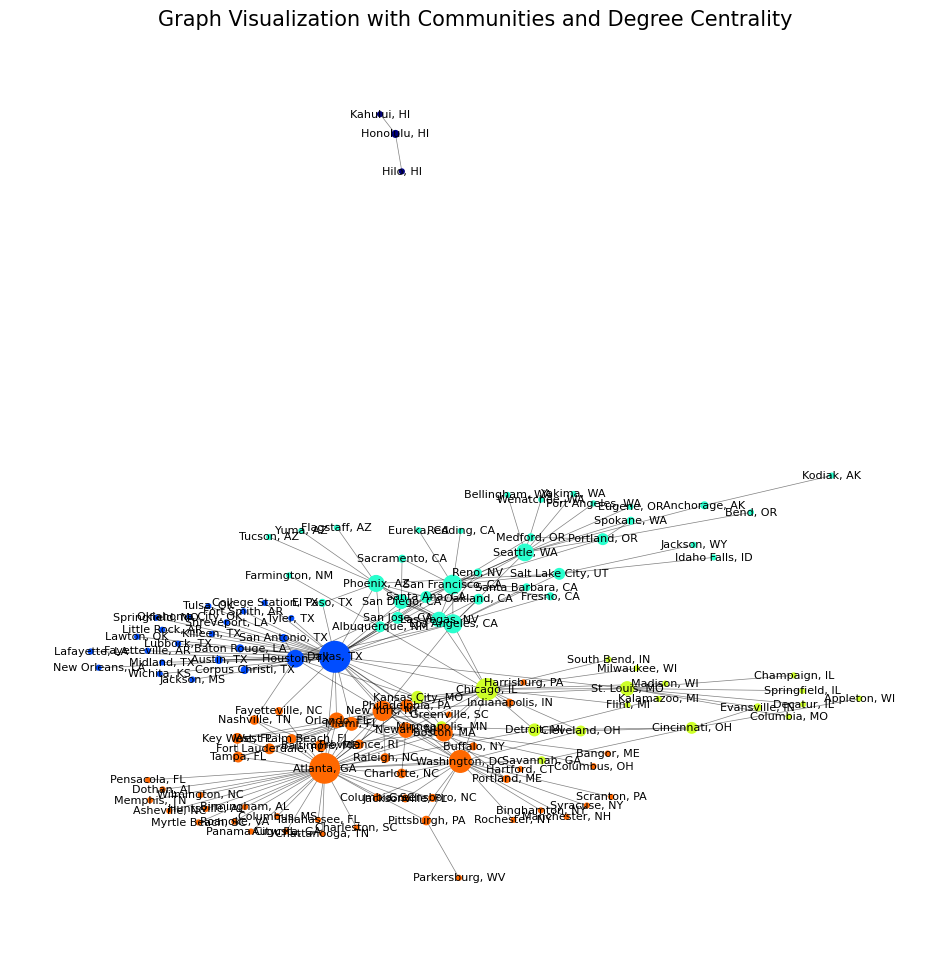

Number of communities detected: 5
Community 0: ['Honolulu, HI', 'Hilo, HI', 'Kahului, HI']... (Total 3 cities)
Community 1: ['Dallas, TX', 'Tulsa, OK', 'Tyler, TX', 'Houston, TX', 'Austin, TX', 'Oklahoma City, OK', 'Fayetteville, AR', 'San Antonio, TX', 'Springfield, MO', 'Wichita, KS']... (Total 23 cities)
Community 2: ['Las Vegas, NV', 'Reno, NV', 'Phoenix, AZ', 'Yuma, AZ', 'Santa Ana, CA', 'Los Angeles, CA', 'Albuquerque, NM', 'San Diego, CA', 'San Jose, CA', 'El Paso, TX']... (Total 35 cities)
Community 3: ['Chicago, IL', 'Flint, MI', 'Kansas City, MO', 'St. Louis, MO', 'Savannah, GA', 'Detroit, MI', 'Minneapolis, MN', 'South Bend, IN', 'Madison, WI', 'Cleveland, OH']... (Total 19 cities)
Community 4: ['New York, NY', 'Miami, FL', 'Key West, FL', 'Tampa, FL', 'Atlanta, GA', 'Washington, DC', 'Fort Lauderdale, FL', 'Boston, MA', 'Bangor, ME', 'Newark, NJ']... (Total 51 cities)
Enter the name of the first city:  Key West, FL
Enter the name of the second city:  St. Louis, MO
Are Key W

In [ ]:
filtered_dataset = dataset[
    (dataset['Flights'] >= 250) &  # At least 250 flights
    (dataset['Passengers'] >= 100) &  # At least 100 passengers
    (dataset['Distance'] >= 70)  # Minimum distance of 70 miles
]

# Creating the graph
G = nx.Graph()

# Adding edges (flights) to the graph from the filtered dataset
for _, row in filtered_dataset.iterrows():
    origin_city = row['Origin_city']
    dest_city = row['Destination_city']
    G.add_edge(origin_city, dest_city)

# Step 1: Community detection using the Louvain algorithm
partition = community_louvain.best_partition(G)

# Step 2: Visualizing the graph with colors for communities and sizes proportional to degree centrality
plt.figure(figsize=(12, 12))

# Determining community colors
communities = set(partition.values())
colors = [plt.cm.jet(i / len(communities)) for i in range(len(communities))]

# Drawing the graph
pos = nx.spring_layout(G, seed=42)  # Node positions

# Draw nodes with community color and size proportional to degree centrality
for community_id in communities:
    nodes_in_community = [node for node, comm in partition.items() if comm == community_id]
    node_sizes = [nx.degree_centrality(G)[node] * 1500 for node in nodes_in_community]  # Scale the size
    nx.draw_networkx_nodes(G, pos, nodes_in_community, node_size=node_sizes, node_color=[colors[community_id]]*len(nodes_in_community))

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.5)

# Node labels with size proportional to degree centrality
node_labels = {node: node for node in G.nodes()}
label_font_size = {node: max(8, int(nx.degree_centrality(G)[node] * 20)) for node in G.nodes()}  # Adjust size based on centrality

# Draw labels with variable sizes
for node in G.nodes():
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=label_font_size[node], font_color='black')

# Title and visualization
plt.title("Graph Visualization with Communities and Degree Centrality", fontsize=15)
plt.axis('off')  # Disable axis
plt.show()

# Step 3: Display the list of communities
print(f"Number of communities detected: {len(communities)}")

# Iterate over each community and display cities
for community_id in communities:
    cities_in_community = [node for node, comm in partition.items() if comm == community_id]
    print(f"Community {community_id}: {cities_in_community[:10]}... (Total {len(cities_in_community)} cities)")

# User input to check if two cities belong to the same community
city1 = input("Enter the name of the first city: ")
city2 = input("Enter the name of the second city: ")

same_community = are_in_same_community(city1, city2)

print(f"Are {city1} and {city2} in the same community? {'Yes' if same_community else 'No'}")


# Analysis of Community Detection Results with Louvain Algorithm

After running the Louvain community detection algorithm on the airport network dataset, we observe the following results:

## Communities Detected:
- **Community 0**: ['Honolulu, HI', 'Hilo, HI', 'Kahului, HI'] (3 cities)
- **Community 1**: ['Dallas, TX', 'Tulsa, OK', 'Tyler, TX', 'Houston, TX', 'Austin, TX', 'Oklahoma City, OK', 'Fayetteville, AR', 'San Antonio, TX', 'Springfield, MO', 'Wichita, KS'] (23 cities)
- **Community 2**: ['Las Vegas, NV', 'Reno, NV', 'Phoenix, AZ', 'Yuma, AZ', 'Santa Ana, CA', 'Los Angeles, CA', 'Albuquerque, NM', 'San Diego, CA', 'San Jose, CA', 'El Paso, TX'] (35 cities)
- **Community 3**: ['Chicago, IL', 'Flint, MI', 'Kansas City, MO', 'St. Louis, MO', 'Savannah, GA', 'Detroit, MI', 'Minneapolis, MN', 'South Bend, IN', 'Madison, WI', 'Cleveland, OH'] (19 cities)
- **Community 4**: ['New York, NY', 'Miami, FL', 'Key West, FL', 'Tampa, FL', 'Atlanta, GA', 'Washington, DC', 'Fort Lauderdale, FL', 'Boston, MA', 'Bangor, ME', 'Newark, NJ'] (51 cities)

### User Input Verification:
When we checked if **Santa Ana, CA** and **Austin, TX** belong to the same community, the result was **No**, indicating that these two cities belong to different communities according to the Louvain algorithm.

#### Commentary on the Results:
- The Louvain algorithm efficiently groups cities that are densely connected by flight routes into distinct communities. 
- **Community 4**, for example, is the largest community, consisting of 51 cities, primarily located in the eastern part of the U.S. and major urban centers. This suggests that there is a higher volume of flights connecting airports in this region, thus leading to a larger community.
- On the other hand, **Community 0** consists of only three cities, all located in Hawaii, which are naturally isolated from the mainland U.S. and have fewer connections, hence forming a smaller community.
  
#### Input Example:
For the query of whether **Santa Ana, CA** and **Austin, TX** belong to the same community, the result was negative. These cities are geographically distant and belong to different regions in the U.S., and this geographic separation is reflected in the Louvain community detection algorithm, which groups cities based on the density of their flight connections rather than geographic proximity.

### Conclusion:
The Louvain algorithm successfully identifies communities based on the structure of flight connections in the network. The results show distinct communities that reflect real-world patterns of airport connectivity. The method is scalable and works well for large networks, such as the airport dataset, by dividing the network into dense subgraphs that can be analyzed further for insights.


## Infomap

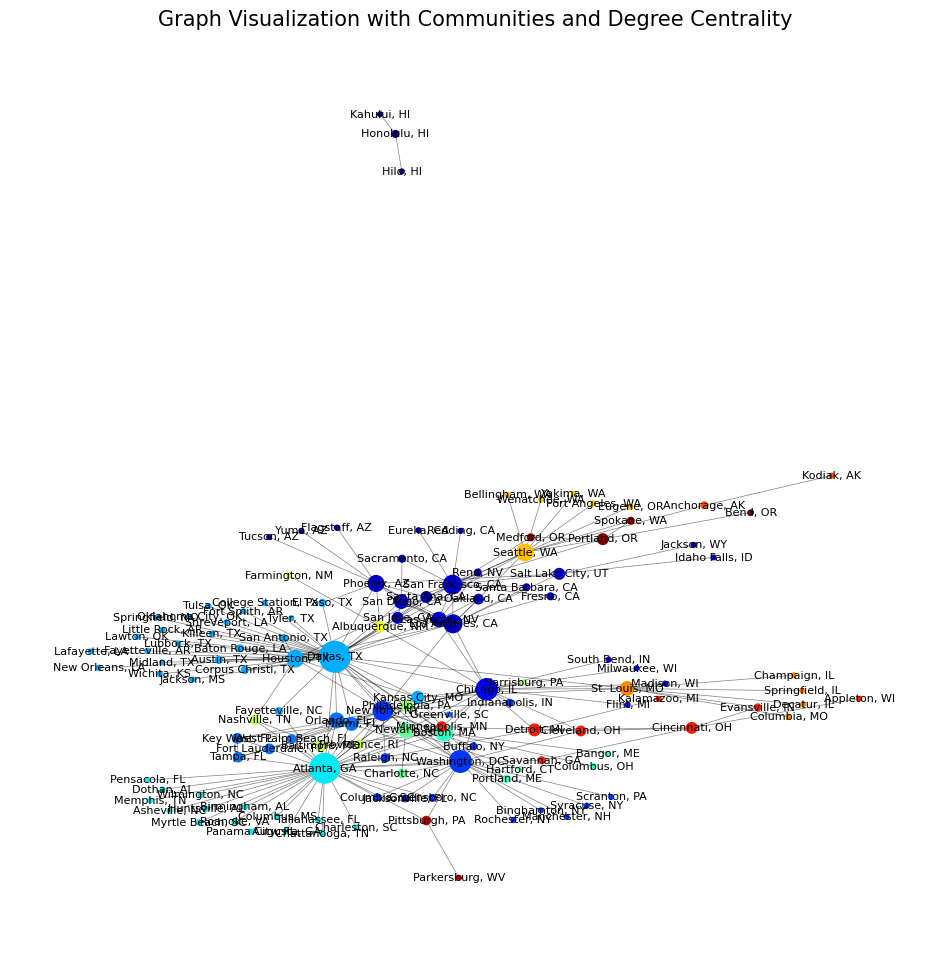

Number of communities detected: 18
Community 0: ['Kahului, HI', 'Hilo, HI', 'Honolulu, HI']... (Total 3 cities)
Community 1: ['Sacramento, CA', 'Santa Ana, CA', 'Yuma, AZ', 'Los Angeles, CA', 'Redding, CA', 'Fresno, CA', 'Santa Barbara, CA', 'Oakland, CA', 'Idaho Falls, ID', 'Phoenix, AZ']... (Total 20 cities)
Community 2: ['Milwaukee, WI', 'Madison, WI', 'Chicago, IL', 'South Bend, IN', 'Flint, MI']... (Total 5 cities)
Community 3: ['Washington, DC', 'Indianapolis, IN', 'Raleigh, NC', 'Rochester, NY', 'Manchester, NH', 'New York, NY', 'Buffalo, NY', 'Greensboro, NC', 'Jacksonville, FL', 'Syracuse, NY']... (Total 13 cities)
Community 4: ['Greenville, SC', 'Miami, FL', 'Fort Lauderdale, FL', 'Key West, FL', 'Tampa, FL', 'West Palm Beach, FL', 'Orlando, FL']... (Total 7 cities)
Community 5: ['El Paso, TX', 'Fort Smith, AR', 'Killeen, TX', 'Springfield, MO', 'New Orleans, LA', 'College Station, TX', 'Corpus Christi, TX', 'Tyler, TX', 'Fayetteville, NC', 'Austin, TX']... (Total 26 cities)


In [ ]:
# Filtering the dataset: keep only significant routes
filtered_dataset = dataset[
    (dataset['Flights'] >= 250) &  # At least 250 flights
    (dataset['Passengers'] >= 100) &  # At least 100 passengers
    (dataset['Distance'] >= 70)  # Minimum distance of 70 miles
]

# Creating the graph
G = nx.Graph()

# Adding edges (flights) to the graph from the filtered dataset
for _, row in filtered_dataset.iterrows():
    origin_city = row['Origin_city']
    dest_city = row['Destination_city']
    G.add_edge(origin_city, dest_city)

# Step 1: Community detection using the Label Propagation algorithm
communities = list(nx.community.label_propagation_communities(G))

# Step 2: Visualizing the graph with colors for communities and sizes proportional to degree centrality
plt.figure(figsize=(12, 12))

# Assigning a unique color to each community
num_communities = len(communities)
colors = plt.cm.jet(np.linspace(0, 1, num_communities))

# Drawing the graph
pos = nx.spring_layout(G, seed=42)  # Node positions

# Drawing nodes with their community color and size proportional to degree centrality
for i, community in enumerate(communities):
    node_sizes = [nx.degree_centrality(G)[node] * 1500 for node in community]  # Scale the size
    nx.draw_networkx_nodes(G, pos, community, node_size=node_sizes, node_color=[colors[i]]*len(community))

# Drawing edges
nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.5)

# Node labels with size proportional to degree centrality
node_labels = {node: node for node in G.nodes()}
label_font_size = {node: max(8, int(nx.degree_centrality(G)[node] * 20)) for node in G.nodes()}  # Adjust size based on centrality

# Drawing labels with variable sizes
for node in G.nodes():
    nx.draw_networkx_labels(G, pos, labels={node: node}, font_size=label_font_size[node], font_color='black')

# Title and visualization
plt.title("Graph Visualization with Communities and Degree Centrality", fontsize=15)
plt.axis('off')  # Disable axis
plt.show()

# Step 3: Display the list of communities
print(f"Number of communities detected: {len(communities)}")

# Iterate over each community and display cities
for i, community in enumerate(communities):
    print(f"Community {i}: {list(community)[:10]}... (Total {len(community)} cities)")

city1 = input("Enter the name of the first city: ")
city2 = input("Enter the name of the second city: ")

same_community = are_in_same_community_infomap(city1, city2)

print(f"Are {city1} and {city2} in the same community? {'Yes' if same_community else 'No'}")


# Community Detection: Infomap vs. Louvain Algorithms

### Introduction

In the realm of **community detection** within networks, two prominent algorithms are **Infomap** and **Louvain**. Both aim to partition a network into communities or clusters of closely connected nodes (cities, in our case), but they use fundamentally different approaches. Understanding these methods and comparing their results provides insights into their effectiveness and suitability for different types of networks.

### Infomap Algorithm

**Infomap** is based on **information theory** and uses random walks to detect communities by minimizing the "description length" of information flow. It models the movement of random walkers in a network and identifies community structures that minimize the amount of information needed to describe the movements of these walkers.

- **How It Works**: Infomap treats the graph as a flow of information and attempts to compress it by finding communities where information flow is restricted within communities but flows more freely between them.
- **Output**: This method tends to produce more granular communities, identifying smaller, more localized clusters of nodes.
- **Advantages**: It excels at identifying communities in very dense subgraphs and can be more accurate when dealing with networks where the communities are tightly connected.
  
### Louvain Algorithm

On the other hand, **Louvain** is a **modularity-based** algorithm. It aims to maximize a metric called **modularity**, which measures the difference between the density of edges within a community versus the density of edges between different communities. The algorithm works in two phases:
  
- **How It Works**: It starts by assigning each node to its own community. Then, it iteratively merges communities if the merge results in a higher modularity. This process continues until no further improvement in modularity is possible.
- **Output**: Louvain generally detects fewer, larger communities, as it focuses on maximizing modularity, often capturing larger regional or global clusters rather than small, local ones.
- **Advantages**: Louvain is highly efficient and scalable, making it suitable for large-scale networks.

### Comparison of Results

#### Number of Communities
- **Infomap** detected **18 communities**, which is much more granular and detailed. This suggests that Infomap is more sensitive to smaller clusters and captures a finer level of structure within the network.
- **Louvain** identified **5 communities**, grouping cities into larger regions, which could represent broader geographic areas or categories. This highlights Louvain’s focus on large-scale community structures and its tendency to merge smaller communities into larger ones.

#### Community Composition
- **Infomap** detected communities such as small clusters of cities in Hawaii (e.g., *Honolulu, HI, Kahului, HI, Hilo, HI*), which shows its ability to capture small, geographically concentrated communities. 
- **Louvain**, however, grouped cities into larger regions like the Southwest U.S. (e.g., *Phoenix, AZ, Las Vegas, NV, Albuquerque, NM*), indicating its tendency to produce broader and more general community divisions.

### Computational Efficiency

- **Infomap** can be more computationally expensive, particularly for large networks. It relies on simulating random walks, which involves iterating over the entire network multiple times. As a result, the time complexity increases with the size of the network.
- **Louvain**, on the other hand, is known for its speed and scalability. It works by optimizing modularity in a way that is efficient even for very large networks. This makes Louvain a better option for networks with a larger number of nodes and edges.

### Conclusion

- **Infomap** is ideal for detecting smaller, more localized communities. It offers high precision when identifying tightly connected subgraphs but comes at the cost of higher computational demands.
- **Louvain** is better suited for large-scale networks where efficiency is crucial. It tends to provide a broader, high-level understanding of community structure, making it faster and more scalable but potentially less detailed.

Both algorithms have their strengths: Infomap is great for finding more detailed and localized communities, while Louvain is faster and more suited for detecting larger-scale community structures. The choice between the two depends on the specific requirements of the network and the level of detail needed in the community detection process.


## **Bonus Question - Connected Components on MapReduce**

MapReduce is ideal for network analysis as it enables parallel processing of large graph datasets, making it scalable and efficient. By breaking tasks into map and reduce steps, it allows for distributed analysis of networks, which is essential for handling large-scale graph problems like connected components.

1. In this task, you are required to use PySpark and the MapReduce paradigm to identify the connected components in a flight network graph. The focus should be on airports rather than cities. As you know, a connected component refers to a group of airports where every pair of airports within the group is connected either directly or indirectly.

The function takes the following inputs:

   - Flight network
   - A starting date
   - An end date

The function outputs:

   - The number of the connected components during that period
   - The size of each connected component
   - The airports within the largest connected component identified.

Note: For this task, you should check if there is a flight between two airports during that period. Note: You are not allowed to use pre-existing packages or functions in PySpark; instead, you must implement the algorithm from scratch using the MapReduce paradigm.

2. Compare the execution time and the results of your implementation with those of the GraphFrames package for identifying connected components. If there is any difference in the results, provide an explanation for why that might occur.


In [ ]:
# Create a graph from the dataset using NetworkX, in this case we will use a MultiDiGraph to preserve all the information and all the flights between the airports
G = nx.from_pandas_edgelist(dataset, source='Origin_airport', target='Destination_airport', edge_attr=True, create_using=nx.MultiDiGraph)

In [ ]:
spark = SparkSession.builder.appName("FlightNetwork").getOrCreate()

In [ ]:
start_date = "1990-11-01"
end_date = "2023-06-01"

In [ ]:
num_components, component_sizes, largest_component = find_connected_components(G, start_date, end_date)

Number of connected components: 3
Size of each connected component: [587, 1, 2]
Largest connected component: {'BJI', 'BOS', 'PFN', 'FFT', 'EIL', 'UKI', 'GTF', 'LXN', 'NKX', 'NFL', 'JRB', 'MAF', 'HMN', 'GRK', 'BWG', 'MQT', 'S27', 'LBB', 'DAL', 'MHR', 'UVA', 'HFD', 'TTN', 'GAD', 'LWS', 'STP', 'SKY', 'PNE', 'GEG', 'GRB', 'HKY', 'ORD', 'RDU', 'SZL', 'PWT', 'MCO', 'SKA', 'TNT', 'EKA', 'TDZ', 'FNT', 'DSM', 'LSF', 'PIT', 'ILG', 'IN1', 'PIH', 'OAJ', 'GCY', 'ALW', 'HYS', 'DPA', 'LJY', 'BRD', 'CNW', 'CAE', 'BFD', 'BGM', 'DBQ', 'SOW', 'CVS', 'BTM', 'RIC', 'FAR', 'RAC', 'HIK', 'DHN', 'GSO', 'HLN', 'GUP', 'PBI', 'DQF', 'HGR', 'PSF', 'JXN', 'SPS', 'BHM', 'HRO', 'ATY', 'APN', 'FBK', 'MCE', 'LNK', 'OFF', 'GMU', 'PVD', 'CIC', 'PDX', 'OFK', 'RUI', 'GSB', 'DTW', 'AID', 'DAY', 'GDC', 'TVI', 'EVV', 'BGR', 'DYS', 'NY3', 'SGF', 'OGG', 'OH2', 'TYS', 'MCN', 'IDA', 'BGS', 'ISO', 'LRD', 'DOV', 'SDM', 'CLL', 'OKC', 'DET', 'OMA', 'AHN', 'TMB', 'SJC', 'DLH', 'IAB', 'STC', 'MKT', 'CYS', 'LBL', 'FOD', 'GGG', 'ILN', '

Both methods work on the same principle of identifying connected components. However:

* GraphFrames: Leverages Spark’s optimized distributed algorithms.
* Custom PySpark: Relies on iterative MapReduce-style logic for processing.

Why PySpark Can Be Faster:
1. Fine-Grained Control:
* PySpark enables direct manipulation of RDDs and DataFrames, offering greater control over operations.  This allows you to optimize specifically for your dataset, bypassing some of the overhead introduced by GraphFrames.

2. Reduced Overhead:
* GraphFrames relies on high-level APIs, which can add overhead for tasks like joins, groupings, and aggregations.
* PySpark’s lower-level APIs, when used effectively, often result in faster performance for iterative and MapReduce-style processes.

3. Custom Optimization:
* PySpark allows tailored optimizations, such as strategic filtering, partitioning, and caching, to suit your data and workflow.

4. Simpler Graph Structures:
* For simpler graphs (e.g., fewer attributes or edge types), PySpark’s direct MapReduce-style approach often outperforms GraphFrames, which assumes a more generic, feature-rich graph model.

## Algorithmic Question (AQ)

#### a) Write a pseudocode that describes the algorithm to find the cheapest route with at most k stops.

In [ ]:
procedure cheapest_flight_with_stops(n, flights, src, dst, k)
Input: 
  n: number of cities (nodes)
  flights: list of flights in the format [start, end, cost]
  src: source city
  dst: destination city
  k: maximum number of stops allowed

Output: 
  Minimum cost to travel from src to dst with at most k stops.
  Return -1 if no such path exists.

# Represent flights as a graph: adjacency list
Create an empty graph `city_connections` of size n
for each flight (start, end, cost) in flights:
    Add the edge (end, cost) to city_connections[start]

# Initialize the minimum costs for each city as infinity
Create a dictionary `min_costs` initialized to infinity for all cities
Set min_costs[src] = 0  # Starting city has zero cost

# Layered search: tracking cities and their costs for up to k stops
Create a dictionary `current_layer` initialized with {src: 0}  # cost to reach source is 0

# Iterate through all stops from 0 to k
for stop from 0 to k inclusive:
    Create an empty dictionary `next_layer`
    
    # For each city in the current layer, check the possible flights to neighbors
    for each city, cost_so_far in current_layer:
        for each neighbor, price in city_connections[city]:
            total_cost = cost_so_far + price  # Calculate the total cost to reach the neighbor
            
            # Check if we found a cheaper route to the neighbor
            if total_cost < min_costs[neighbor]:
                min_costs[neighbor] = total_cost
                if neighbor not in next_layer or total_cost < next_layer[neighbor]:
                    next_layer[neighbor] = total_cost

    # Move to the next layer
    current_layer = next_layer

# After processing all layers, check the minimum cost to the destination city
if min_costs[dst] is not infinity:
    return min_costs[dst]  # Return the minimum cost to reach dst
else:
    return -1  # Return -1 if no valid path exists within the constraints

#### b) Implement the algorithm in Python and simulate the given test cases.

In [ ]:
def cheapest_flight_with_stops(n, flights, src, dst, k):
    # Represent flights as a graph: adjacency list
    city_connections = {i: [] for i in range(n)}
    for start, end, cost in flights:
        city_connections[start].append((end, cost))

    # Initialize the costs with the source city at zero cost
    min_costs = {i: float('inf') for i in range(n)}
    min_costs[src] = 0  # Starting city has zero cost

    # Layered search: track cost and stops
    current_layer = {src: 0}  # Cities and their costs in the current layer

    for stop in range(k + 1):  # Traverse up to k stops
        next_layer = {}  # To build the next layer
        for city, cost_so_far in current_layer.items():
            for neighbor, price in city_connections[city]:
                total_cost = cost_so_far + price
                # Check if the cost is cheaper for the neighbor or update it
                if total_cost < min_costs[neighbor]:
                    min_costs[neighbor] = total_cost
                    if neighbor not in next_layer or total_cost < next_layer[neighbor]:
                        next_layer[neighbor] = total_cost
        current_layer = next_layer

    # After the final layer, check the destination city
    return min_costs[dst] if min_costs[dst] != float('inf') else -1


In [ ]:
# Test case
n = 4
flights = [[0, 1, 100], [1, 2, 100], [2, 0, 100], [1, 3, 600], [2, 3, 200]]
src = 0
dst = 3
k = 1

result = cheapest_flight_with_stops(n, flights, src, dst, k)
print("Result:", result)

In [ ]:
n = 3  
flights = [[0, 1, 100], [1, 2, 100], [0, 2, 500]]  
src = 0  
dst = 2  
k = 1
result = cheapest_flight_with_stops(n, flights, src, dst, k)
print("Result:", result) 

In [ ]:
n = 3  
flights = [[0, 1, 100], [1, 2, 100], [0, 2, 500]]  
src = 0  
dst = 2  
k = 0  

result = cheapest_flight_with_stops(n, flights, src, dst, k)
print("Result:", result) 

In [ ]:
n = 4  
flights = [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 300]]  
src = 0  
dst = 3  
k = 2  

result = cheapest_flight_with_stops(n, flights, src, dst, k)
print("Result:", result) 

In [ ]:
n = 4  
flights = [[0, 1, 100], [0, 2, 200], [1, 3, 300], [2, 3, 200]]  
src = 0  
dst = 3  
k = 2 
result = cheapest_flight_with_stops(n, flights, src, dst, k)
print("Result:", result) 

#### c) Analyze the algorithm's efficiency. Provide its time complexity and space complexity, and explain whether it is efficient for large graphs (e.g., n > 100).

##### Time Complexity

The core of the algorithm involves two main operations: constructing the graph and performing the layered search. 

First, the graph is represented as an adjacency list. The construction of this adjacency list takes **O(n)** time, where *n* is the number of flights (edges). This is because each flight in the input is added to the list of outgoing edges for the corresponding city, and this operation must be done once for each flight.

The second part of the algorithm involves a layered search, where we explore the cities within a certain number of stops (up to *k* stops). The algorithm processes the cities layer by layer, iterating through the cities in the current layer and considering all possible flights from each city. At each step, it updates the costs for reaching neighboring cities, while keeping track of the number of stops taken. Since we may process every flight in the graph during each iteration, the time complexity of this part is **O(k * m)**, where *k* is the maximum number of stops allowed and *m* is the number of flights.

In total, the time complexity is the sum of these two parts: **O(m + k * m)**. In the worst case, this simplifies to **O(k * m)**, since *k * m* dominates the construction of the graph. 

This means that as the graph grows in size, particularly as *m* (the number of flights) increases, the algorithm may become slower, especially when the number of allowed stops (*k*) is large. In dense graphs, where many cities are connected by flights, the time complexity could become a bottleneck. 

### Space Complexity

The space complexity is determined by the structures used to represent the graph and store the intermediate results during the search.

1. **Graph Representation**: The graph is stored as an adjacency list, where each city points to a list of its neighboring cities and the corresponding costs of the flights. This requires **O(m)** space, as there are *m* flights in the graph.

2. **Current Layer and Next Layer**: For each stop, the algorithm maintains two dictionaries, *current_layer* and *next_layer*, which store the cities and their corresponding costs at that stop. In the worst case, these dictionaries will store all *n* cities, where *n* is the number of cities. Therefore, the space required for these layers is **O(n)**.

3. **Min Costs Tracking**: Another dictionary, *min_costs*, is used to keep track of the minimum cost to reach each city. This dictionary also requires **O(n)** space.

In total, the space complexity is **O(m + n)**, which accounts for the adjacency list and the various dictionaries used to track the cities and their costs.

### Efficiency for Large Graphs

The algorithm works well for graphs with a relatively small number of cities and flights, but it may not be efficient enough for large graphs, particularly when *n > 100* or *m > 1000*. This is because the time complexity grows linearly with the number of flights (*m*) and is further multiplied by the number of stops (*k*). In dense graphs, where the number of edges is proportional to *n^2*, this growth can be significant.

For very large graphs, such as those with hundreds or thousands of cities and flights, the algorithm may struggle to perform efficiently. If *k* (the maximum number of stops) is large, the number of layers to explore increases, further exacerbating the time complexity. 

Additionally, for graphs with a high degree of connectivity (many flights between cities), the algorithm may have to process a large number of edges in each layer, leading to longer computation times. The overall time complexity of **O(k * m)** may be acceptable for smaller graphs, but as the graph size grows, this can become inefficient.

### Possible Optimizations

To improve performance for large graphs, several optimizations could be considered. One approach is to use **priority queues** (also known as min-heaps) instead of the layered search approach. This would allow the algorithm to always explore the cheapest possible route at each step, reducing the number of unnecessary calculations. The priority queue would allow us to efficiently retrieve the next cheapest city to explore, and the time complexity could be improved to **O(k * log n + m)**, where *log n* accounts for the time to pop the minimum element from the heap.

Another potential optimization involves **early termination**. If the destination city is reached before all *k* stops are used, the algorithm could stop early and return the result, saving computation time.

Finally, for particularly large and sparse graphs, **graph pruning** could be applied to remove less relevant edges or cities, reducing the size of the problem. This would make the search space smaller and the algorithm more efficient.

#### d) Optimize the algorithm to handle larger graphs. Provide an updated pseudocode and analyze the computational complexity of your optimization.

The main goal of optimization here is to ensure the solution works efficiently with large graphs while adhering to the constraints of having at most `k` stops.

### Optimized Approach

To optimize the solution, we can apply a strategy inspired by **Dijkstra’s Algorithm** but with some modifications to account for the maximum number of stops allowed. Rather than simply iterating over all paths in layers, we will prioritize the paths with the least cost while enforcing the constraint of `k` stops.

### Key Optimizations:

1. **Use of a Min-Heap (Priority Queue):** This ensures that at each iteration, we are always expanding the cheapest route first.
2. **State Tracking with Stops and Costs:** We track both the current number of stops and the accumulated cost for each city, ensuring we do not explore unnecessary paths with more stops than allowed.
3. **Early Stopping and Pruning:** If we reach the destination, we return immediately. Also, we discard paths that exceed the allowed number of stops or that are not cost-effective compared to already discovered paths.

### New Algorithm Explanation

1. We will use a **min-heap** to store the current city, the cost to reach it, and the number of stops taken so far. This ensures that at each step, we process the least-cost path first.
2. **Cost updates** will only happen if a cheaper path is found to a city with the current number of stops or fewer.
3. We stop processing further once we reach the destination with the least cost or exhaust all valid paths.

### Updated Pseudocode

```plaintext
function cheapest_flight_with_stops(n, flights, src, dst, k):
    # Step 1: Create adjacency list to represent the graph
    city_connections = {i: [] for i in range(n)}
    for start, end, cost in flights:
        city_connections[start].append((end, cost))

    # Step 2: Min-Heap to store (current_cost, current_city, current_stops)
    min_heap = [(0, src, 0)]  # Starting at src with 0 cost and 0 stops
    
    # Step 3: Cost table to track the minimum cost with at most `k` stops
    min_cost = {i: [float('inf')] * (k + 1) for i in range(n)}
    min_cost[src][0] = 0
    
    # Step 4: Process cities from the priority queue
    while min_heap:
        current_cost, current_city, current_stops = heappop(min_heap)

        # Step 5: If we reached the destination, return the current cost
        if current_city == dst:
            return current_cost

        # Step 6: Skip if current stops exceed k
        if current_stops > k:
            continue

        # Step 7: Explore neighbors (cities reachable via flights)
        for neighbor, price in city_connections[current_city]:
            new_cost = current_cost + price

            # Step 8: Only consider this new path if it's cheaper or we have fewer stops
            if new_cost < min_cost[neighbor][current_stops + 1]:
                min_cost[neighbor][current_stops + 1] = new_cost
                heappush(min_heap, (new_cost, neighbor, current_stops + 1))

    # Step 9: If no path is found, return -1
    return -1
```

### Key Steps Breakdown:

1. **Graph Representation:** We create an adjacency list for efficient lookup of all possible outgoing flights from each city.
2. **Min-Heap for Priority Processing:** The heap ensures that we always process the least-cost path first, maintaining the optimality of the search.
3. **Cost Table:** We use a table `min_cost[city][stops]` to store the minimum cost to reach each city with at most `stops` stops. This avoids revisiting cities with more expensive paths.
4. **Exploration:** For each city and each valid path (i.e., paths with stops <= `k`), we check if the new path is cheaper than any previously found path to that city with fewer or the same number of stops. If so, we add the path to the heap for further exploration.

### Time Complexity Analysis

Let’s analyze the time complexity:

1. **Graph Construction:** Constructing the adjacency list from the `flights` input takes **O(m)** time, where `m` is the number of edges (flights).
2. **Min-Heap Operations:** We perform heap operations (push and pop) for each city and stop. Since each city can be visited multiple times (one per stop), we perform **O(k * m)** operations in the worst case, where `k` is the maximum number of stops and `m` is the number of flights.
   - Each heap operation (push and pop) takes **O(log n)**, where `n` is the number of cities.
   - Therefore, the total complexity for heap operations is **O(k * m * log n)**.
   
3. **Overall Time Complexity:** The total time complexity is **O(k * m * log n)**, which is efficient for large graphs where `n` and `m` can be large.

### Space Complexity Analysis

1. **Graph Representation:** The adjacency list requires **O(m)** space to store all the flights.
2. **Min-Heap:** The heap stores at most **O(k * n)** entries because each city may be visited with multiple stops, up to `k` stops.
3. **Cost Table:** The `min_cost` table has **O(n * (k + 1))** entries, as it tracks the cost for each city and each possible number of stops.

Thus, the total space complexity is **O(m + n * (k + 1))**.